In [1]:
using Optim, Dates, DiffEqParamEstim, Plots, Flux, DiffEqFlux, OrdinaryDiffEq

In [2]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,l2s,times,count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

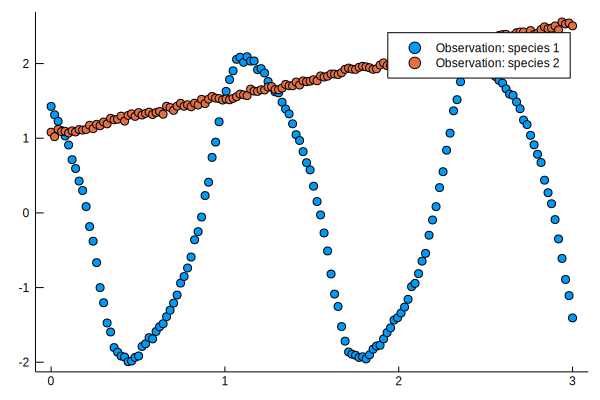

In [3]:
st = 150
step_size = 1

x_all = [1.3757,1.2855,1.1886,1.0838,0.97015,0.84604,0.70974,0.55923,0.39225,0.20644,-7.3987E-5,-0.22811,-0.47624,-0.73895,-1.006,-1.2625,-1.4921,-1.6815,-1.8242,-1.9214,-1.979,-2.005,-2.0069,-1.9911,-1.962,-1.923,-1.8764,-1.8236,-1.7654,-1.7023,-1.6347,-1.5623,-1.4851,-1.4027,-1.3144,-1.2197,-1.1175,-1.0067,-0.88605,-0.75376,-0.60793,-0.44636,-0.26666,-0.066777,0.15455,0.39677,0.65579,0.92293,1.1845,1.4242,1.6272,1.7847,1.8957,1.9648,1.9998,2.0085,1.9976,1.9723,1.9361,1.8917,1.8407,1.7841,1.7225,1.6563,1.5854,1.5098,1.429,1.3427,1.25,1.1503,1.0423,0.92493,0.79647,0.65509,0.49868,0.32491,0.13151,-0.08306,-0.31898,-0.57347,-0.83929,-1.1043,-1.3526,-1.5683,-1.7406,-1.8658,-1.9472,-1.9921,-2.0082,-2.0028,-1.9815,-1.9484,-1.9064,-1.8573,-1.8023,-1.7423,-1.6775,-1.6081,-1.534,-1.4548,-1.3703,-1.2797,-1.1823,-1.077,-0.96273,-0.83791,-0.70078,-0.54931,-0.38123,-0.19417,0.013676,0.24304,0.49229,0.75562,1.0225,1.2778,1.5052,1.6918,1.8316,1.9261,1.9815,2.0058,2.0064,1.9896,1.9598,1.9203,1.8733,1.8201,1.7616,1.6982,1.6303,1.5577,1.4801,1.3973,1.3087,1.2135,1.1108,0.9995,0.87815,0.74508,0.59832,0.43569,0.25479,0.053586,-0.16909,-0.41252,-0.67236,-0.93959,-1.2003,-1.4381,-1.6384,-1.793,-1.9011,-1.9679,-2.001,-2.0083,-1.9964,-1.9703,-1.9336,-1.8887,-1.8373,-1.7804,-1.7185,-1.652,-1.5809,-1.5049,-1.4238,-1.3371,-1.244,-1.1438,-1.0353,-0.91724,-0.78803,-0.64577,-0.48834,-0.31342,-0.11873,0.097212,0.33441,0.58986,0.85604,1.1205,1.3672,1.5805,1.7498,1.8721,1.951,1.9938,2.0084,2.0019,1.9797,1.946,1.9035,1.854,1.7987,1.7383,1.6733,1.6036,1.5292,1.4497,1.3648,1.2738,1.1759,1.0701,0.95521,0.82969,0.69173,0.53927,0.37005,0.18178,-0.02746,-0.25816,-0.50849,-0.77243,-1.0391,-1.2931,-1.5182,-1.702,-1.8388,-1.9306,-1.9838,-2.0064,-2.0058,-1.988,-1.9576,-1.9175,-1.8701,-1.8165,-1.7577,-1.6941,-1.6258,-1.5529,-1.475,-1.3919,-1.3029,-1.2072,-1.104,-0.99212,-0.87007,-0.7362,-0.58853,-0.42478,-0.24265,-0.040142,0.1839,0.42859,0.68919,0.95649,1.2162,1.452,1.6496,1.8012,1.9065,1.971,2.0022,2.0081,1.9952,1.9683,1.931,1.8856,1.8339,1.7766,1.7145,1.6477,1.5762,1.5,1.4185,1.3314,1.2379,1.1372,1.0282,0.90945,0.77948,0.63634,0.47789,0.30175,0.10578,-0.1115,-0.35001,-0.6064,-0.87291,-1.1367,-1.3818,-1.5925,-1.7588,-1.8783,-1.9547,-1.9955,-2.0086,-2.0009,-1.9779,-1.9436,-1.9006,-1.8507,-1.7951,-1.7344,-1.6691,-1.5991,-1.5243,-1.4446,-1.3593,-1.2679,-1.1695,-1.0632,-0.94769,-0.82143,-0.68262,-0.52921,-0.35886,-0.16928,0.041254,0.27328,0.5247,0.78917,1.0555,1.3082,1.5311,1.7119,1.8458,1.935,1.9861,2.007,2.0052,1.9865,1.9553,1.9148,1.8669,1.813,1.7539,1.69,1.6214,1.5482,1.4701,1.3866,1.2971,1.2011,1.0974,0.98488,0.86215,0.72748,0.57886,0.41407,0.23072,0.026874,-0.1985,-0.44432,-0.70567,-0.97295,-1.2317,-1.4655,-1.6603,-1.809,-1.9116,-1.9737,-2.0032,-2.0078,-1.9938,-1.9662,-1.9284,-1.8826,-1.8305,-1.7729,-1.7105,-1.6434,-1.5716,-1.495,-1.4133,-1.3258,-1.2319,-1.1307,-1.0211,-0.90171,-0.77097,-0.62694,-0.46746,-0.29015,-0.092877,0.12575,0.3655,0.6228,0.88957,1.1527,1.396,1.6042,1.7676,1.8842,1.9582,1.997,2.0086,1.9999,1.9761,1.9411,1.8976,1.8474,1.7914,1.7305,1.6648,1.5945,1.5195,1.4394,1.3538,1.262,1.1631,1.0563,0.94015,0.81316,0.67351,0.5191,0.34763,0.15678,-0.055102,-0.28843,-0.5409,-0.80586,-1.0718,-1.3231,-1.5436,-1.7216,-1.8527,-1.9392,-1.9882,-2.0075,-2.0044,-1.9849,-1.9531,-1.912,-1.8637,-1.8095,-1.75,-1.6858,-1.617,-1.5435,-1.465,-1.3812,-1.2914,-1.1948,-1.0906,-0.97753,-0.85412,-0.71864,-0.56907,-0.4032,-0.21862,-0.013441,0.21327,0.46025,0.7223,0.98951,1.2471,1.4789,1.671,1.8167,1.9166,1.9765,2.0042,2.0074,1.9925,1.9641,1.9257,1.8795,1.827,1.7691,1.7064,1.639,1.567,1.4901,1.408,1.3201,1.2258,1.1241,1.0139,0.8939,0.76239,0.61746,0.45693,0.27844,0.079855,-0.14013,-0.38111,-0.6393,-0.90627,-1.1687,-1.4102,-1.6158,-1.7763,-1.89,-1.9616,-1.9985,-2.0086,-1.9988,-1.9742,-1.9386,-1.8947,-1.844,-1.7878,-1.7265,-1.6606,-1.59,-1.5147,-1.4342,-1.3482,-1.256,-1.1567,-1.0493,-0.93255,-0.80482,-0.66431,-0.50889,-0.33628,-0.14416,0.069081,0.30371,0.5572,0.82261,1.0882,1.3379,1.5561,1.7312,1.8593,1.9433,1.9902,2.0079,2.0036,1.9832,1.9507,1.9092,1.8605,1.8059,1.7461,1.6817,1.6125,1.5387,1.4599,1.3757,1.2855,1.1885,1.0838,0.9701,0.84599,0.70969,0.55916,0.39216,0.20639,-0.0001708,-0.22823,-0.47634,-0.73908,-1.0061,-1.2627,-1.4922,-1.6815,-1.8243,-1.9214,-1.979,-2.005,-2.0069,-1.991,-1.9619,-1.923,-1.8763,-1.8235,-1.7653,-1.7023,-1.6346,-1.5623,-1.485,-1.4026,-1.3143,-1.2196,-1.1174,-1.0066,-0.88591,-0.75362,-0.60779,-0.44617,-0.26645,-0.066574,0.15476,0.39705,0.65606,0.92322,1.1848,1.4244,1.6274,1.7849,1.8958,1.9649,1.9999,2.0086,1.9976,1.9723,1.9361,1.8917,1.8406,1.784,1.7225,1.6563,1.5854,1.5097,1.429,1.3426,1.25,1.1502,1.0423,0.92485,0.79637,0.65499,0.49858,0.32478,0.13138,-0.083202,-0.31915,-0.57365,-0.83949,-1.1045,-1.3528,-1.5685,-1.7407,-1.8659,-1.9473,-1.9921,-2.0082,-2.0028,-1.9815,-1.9484,-1.9063,-1.8572,-1.8023,-1.7422,-1.6775,-1.6081,-1.5339,-1.4548,-1.3702,-1.2796,-1.1822,-1.077,-0.96266,-0.83783,-0.7007,-0.54922,-0.38113,-0.19405,0.013802,0.24318,0.49244,0.75578,1.0227,1.278,1.5053,1.6919,1.8317,1.9261,1.9815,2.0058,2.0064,1.9896,1.9598,1.9203,1.8732,1.82,1.7615,1.6982,1.6302,1.5576,1.4801,1.3973,1.3087,1.2135,1.1108,0.99944,0.87808,0.745,0.59824,0.4356,0.25469,0.053481,-0.1692,-0.41265,-0.67249,-0.93973,-1.2004,-1.4382,-1.6385,-1.793,-1.9012,-1.9679,-2.0011,-2.0084,-1.9964,-1.9703,-1.9335,-1.8887,-1.8373,-1.7804,-1.7185,-1.652,-1.5808,-1.5049,-1.4238,-1.337,-1.244,-1.1437,-1.0352,-0.91719,-0.78797,-0.64571,-0.48829,-0.31333,-0.11864,0.097289,0.33451,0.58997,0.85616,1.1206,1.3673,1.5805,1.7498,1.8721,1.9511,1.9938,2.0084,2.0019,1.9797,1.946,1.9035,1.854,1.7987,1.7383,1.6733,1.6036,1.5291,1.4497,1.3648,1.2738,1.1759,1.0701,0.9552,0.82966,0.6917,0.53925,0.37004,0.18172,-0.02748,-0.25818,-0.50853,-0.77245,-1.0391,-1.2931,-1.5183,-1.702,-1.8388,-1.9307,-1.9839,-2.0064,-2.0058,-1.9881,-1.9576,-1.9176,-1.8701,-1.8165,-1.7577,-1.6941,-1.6259,-1.5529,-1.4751,-1.3919,-1.3029,-1.2073,-1.1041,-0.99218,-0.87014,-0.73627,-0.58858,-0.42487,-0.24275,-0.040218,0.18381,0.42846,0.68907,0.95636,1.2161,1.4519,1.6495,1.8011,1.9065,1.9709,2.0022,2.0081,1.9951,1.9683,1.931,1.8856,1.8339,1.7766,1.7145,1.6477,1.5762,1.5,1.4185,1.3314,1.2379,1.1372,1.0282,0.90946,0.77949,0.63635,0.47789,0.30178,0.10579,-0.1115,-0.34998,-0.60638,-0.87288,-1.1367,-1.3817,-1.5925,-1.7588,-1.8783,-1.9547,-1.9955,-2.0086,-2.0009,-1.9779,-1.9436,-1.9006,-1.8507,-1.7951,-1.7344,-1.669,-1.5991,-1.5243,-1.4445,-1.3593,-1.2679,-1.1695,-1.0632,-0.94768,-0.82142,-0.68261,-0.52918,-0.35885,-0.16927,0.041287,0.27331,0.52473,0.7892,1.0555,1.3082,1.5311,1.7119,1.8458,1.935,1.9861,2.007,2.0052,1.9865,1.9553,1.9148,1.8669,1.813,1.7539,1.69,1.6214,1.5482,1.47,1.3865,1.2971,1.201,1.0973,0.98482,0.86211,0.72744,0.5788,0.41398,0.23067,0.026782,-0.19861,-0.44442,-0.70579,-0.97304,-1.2318,-1.4655,-1.6604,-1.8091,-1.9116,-1.9738,-2.0032,-2.0078,-1.9938,-1.9662,-1.9283,-1.8825,-1.8304,-1.7728,-1.7104,-1.6433,-1.5715,-1.495,-1.4132,-1.3257,-1.2318,-1.1306,-1.0209,-0.90157,-0.77082,-0.6268,-0.46729,-0.28994,-0.092671,0.12595,0.36578,0.62307,0.88987,1.153,1.3963,1.6044,1.7678,1.8844,1.9583,1.9971,2.0087,1.9999,1.9761,1.9411,1.8976,1.8473,1.7914,1.7304,1.6648,1.5945,1.5195,1.4394,1.3537,1.2619,1.1631,1.0562,0.94007,0.81307,0.67341,0.519,0.3475,0.15664,-0.055243,-0.2886,-0.54108,-0.80605,-1.072,-1.3233,-1.5438,-1.7218,-1.8527,-1.9393,-1.9882,-2.0075,-2.0044,-1.9849,-1.953,-1.912,-1.8637,-1.8094,-1.75,-1.6858,-1.617,-1.5434,-1.465,-1.3811,-1.2913,-1.1948,-1.0906,-0.97746,-0.85404,-0.71855,-0.56898,-0.4031,-0.2185,-0.013315,0.2134,0.4604,0.72246,0.98967,1.2473,1.479,1.6711,1.8168,1.9166,1.9765,2.0042,2.0074,1.9925,1.9641,1.9257,1.8795,1.827,1.7691,1.7064,1.639,1.5669,1.49,1.4079,1.3201,1.2257,1.124,1.0138,0.89383,0.76231,0.61738,0.45685,0.27834,0.079751,-0.14024,-0.38125,-0.63943,-0.90641,-1.1688,-1.4103,-1.6159,-1.7763,-1.8901,-1.9616,-1.9985,-2.0086,-1.9988,-1.9742,-1.9386,-1.8947,-1.844,-1.7877,-1.7265,-1.6605,-1.59,-1.5146,-1.4342,-1.3482,-1.2559,-1.1567,-1.0493,-0.93249,-0.80477,-0.66425,-0.50884,-0.33621,-0.14408,0.069162,0.30381,0.5573,0.82273,1.0883,1.338,1.5562,1.7313,1.8594,1.9434,1.9902,2.0079,2.0036,1.9832,1.9507,1.9092,1.8605,1.8059,1.7461,1.6816,1.6125,1.5387,1.4599,1.3757,1.2855,1.1885,1.0838,0.97009,0.84597,0.70966,0.55914,0.39216,0.20633,-0.00019246,-0.22824,-0.47638,-0.7391,-1.0062,-1.2627,-1.4922,-1.6816,-1.8243,-1.9215,-1.9791,-2.005,-2.0069,-1.991,-1.962,-1.923,-1.8764,-1.8235,-1.7653,-1.7023,-1.6346,-1.5623,-1.4851,-1.4026,-1.3144,-1.2196,-1.1174,-1.0067,-0.88598,-0.75369,-0.60784,-0.44626,-0.26656,-0.066656,0.15468,0.39692,0.65594,0.92308,1.1846,1.4243,1.6273,1.7848,1.8957,1.9648,1.9998,2.0085,1.9976,1.9722,1.9361,1.8917,1.8406,1.784,1.7225,1.6563,1.5854,1.5098,1.429,1.3426,1.25,1.1502,1.0423,0.92486,0.79639,0.655,0.49858,0.3248,0.13139,-0.083202,-0.31913,-0.57363,-0.83945,-1.1045,-1.3527,-1.5685,-1.7406,-1.8658,-1.9473,-1.9921,-2.0082,-2.0028,-1.9815,-1.9484,-1.9063,-1.8572,-1.8023,-1.7422,-1.6775,-1.608,-1.5339,-1.4548,-1.3702,-1.2796,-1.1822,-1.0769,-0.96265,-0.83782,-0.70069,-0.5492,-0.38111,-0.19405,0.013833,0.24322,0.49246,0.75581,1.0227,1.278,1.5054,1.6919,1.8317,1.9261,1.9815,2.0058,2.0064,1.9896,1.9598,1.9203,1.8732,1.82,1.7615,1.6982,1.6302,1.5576,1.4801,1.3973,1.3086,1.2134,1.1107,0.99939,0.87804,0.74496,0.59818,0.43551,0.25464,0.053397,-0.16932,-0.41275,-0.67261,-0.93981,-1.2006,-1.4383,-1.6385,-1.7931,-1.9012,-1.968,-2.0011,-2.0083,-1.9964,-1.9702,-1.9335,-1.8886,-1.8372,-1.7803,-1.7184,-1.6519,-1.5808,-1.5048,-1.4237,-1.3369,-1.2439,-1.1436,-1.0351,-0.91705,-0.78782,-0.64557,-0.48812,-0.31312,-0.11844,0.09748,0.33478,0.59024,0.85646,1.1209,1.3676,1.5808,1.75,1.8723,1.9512,1.9939,2.0085,2.0019,1.9797,1.946,1.9034,1.8539,1.7987,1.7383,1.6732,1.6035,1.5291,1.4496,1.3647,1.2737,1.1758,1.07,0.95512,0.82957,0.6916,0.53915,0.36991,0.18158,-0.027622,-0.25835,-0.50871,-0.77264,-1.0393,-1.2933,-1.5184,-1.7021,-1.8389,-1.9307,-1.9839,-2.0064,-2.0058,-1.988,-1.9576,-1.9176,-1.8701,-1.8165,-1.7577,-1.6941,-1.6258,-1.5529,-1.475,-1.3919,-1.3029,-1.2072,-1.104,-0.99211,-0.87006,-0.73618,-0.58849,-0.42477,-0.24263,-0.040095,0.18394,0.42861,0.68922,0.95651,1.2162,1.452,1.6496,1.8012,1.9065,1.9709,2.0022,2.0081,1.9951,1.9682,1.9309,1.8856,1.8338,1.7766,1.7144,1.6476,1.5762,1.4999,1.4185,1.3314,1.2379,1.1372,1.0281,0.9094,0.77942,0.63627,0.47781,0.30168,0.10569,-0.11161,-0.35011,-0.60651,-0.87302,-1.1369,-1.3819,-1.5926,-1.7589,-1.8783,-1.9547,-1.9955,-2.0086,-2.0009,-1.9779,-1.9436,-1.9005,-1.8506,-1.795,-1.7344,-1.669,-1.599,-1.5243,-1.4445,-1.3592,-1.2678,-1.1695,-1.0632,-0.94763,-0.82136,-0.68255,-0.52912,-0.35877,-0.16918,0.04137,0.2734,0.52483,0.7893,1.0556,1.3083,1.5312,1.712,1.8459,1.9351,1.9861,2.007,2.0052,1.9865,1.9553,1.9148,1.8669,1.813,1.7539,1.6899,1.6214,1.5482,1.47,1.3865,1.2971,1.201,1.0973,0.98481,0.86208,0.7274,0.57878,0.41398,0.23062,0.026756,-0.19863,-0.44446,-0.70582,-0.9731,-1.2318,-1.4656,-1.6604,-1.8091,-1.9117,-1.9738,-2.0032,-2.0078,-1.9938,-1.9662,-1.9283,-1.8826,-1.8304,-1.7729,-1.7104,-1.6433,-1.5716,-1.495,-1.4132,-1.3257,-1.2318,-1.1306,-1.021,-0.90164,-0.77089,-0.62685,-0.46736,-0.29005,-0.092758,0.12589,0.36564,0.62295,0.88972,1.1529,1.3961,1.6043,1.7677,1.8843,1.9582,1.997,2.0086,1.9998,1.9761,1.9411,1.8976,1.8473,1.7914,1.7304,1.6648,1.5945,1.5195,1.4394,1.3537,1.2619,1.1631,1.0562,0.94008,0.81308,0.67342,0.519,0.34752,0.15666,-0.055241,-0.28858,-0.54106,-0.80602,-1.072,-1.3232,-1.5438,-1.7217,-1.8527,-1.9393,-1.9882,-2.0075,-2.0044,-1.9849,-1.953,-1.912,-1.8637,-1.8094,-1.75,-1.6858,-1.617,-1.5434,-1.465,-1.3811,-1.2913,-1.1948,-1.0905,-0.97745,-0.85403,-0.71854,-0.56896,-0.40307,-0.2185,-0.013284,0.21344,0.46043,0.72249,0.9897,1.2473,1.479,1.6711,1.8168,1.9166,1.9765,2.0042,2.0074,1.9924,1.9641,1.9257,1.8795,1.827,1.7691,1.7063,1.639,1.5669,1.49,1.4079,1.32,1.2257,1.124,1.0138,0.89378,0.76228,0.61732,0.45676,0.27828,0.079676,-0.14036,-0.38135,-0.63955,-0.9065,-1.1689,-1.4104,-1.6159,-1.7764,-1.8901,-1.9616,-1.9985,-2.0086,-1.9987,-1.9741,-1.9386,-1.8946,-1.8439,-1.7877,-1.7264,-1.6605,-1.5899,-1.5145,-1.4341,-1.3481,-1.2559,-1.1566,-1.0492,-0.93236,-0.80462,-0.6641,-0.50868,-0.33599,-0.14387,0.069345,0.30407,0.55758,0.82302,1.0885,1.3383,1.5564,1.7315,1.8595,1.9435,1.9903,2.0079,2.0037,1.9832,1.9507,1.9092,1.8604,1.8058,1.7461,1.6816,1.6125,1.5386,1.4598,1.3756,1.2854,1.1884,1.0837,0.97001,0.84588,0.70956,0.55904,0.39203,0.20619,-0.00033804,-0.2284,-0.47656,-0.73928,-1.0064,-1.2628,-1.4924,-1.6817,-1.8244,-1.9215,-1.9791,-2.005,-2.0069,-1.991,-1.962,-1.923,-1.8763,-1.8235,-1.7653,-1.7023,-1.6346,-1.5622,-1.485,-1.4026,-1.3143,-1.2195,-1.1173,-1.0066,-0.8859,-0.7536,-0.60775,-0.44616,-0.26644,-0.066535,0.15481,0.39707,0.6561,0.92324,1.1848,1.4244,1.6274,1.7848,1.8958,1.9649,1.9998,2.0085,1.9976,1.9722,1.9361,1.8916,1.8406,1.784,1.7225,1.6562,1.5854,1.5097,1.4289,1.3426,1.2499,1.1502,1.0422,0.92479,0.79632,0.65492,0.4985,0.3247,0.13129,-0.083309,-0.31926,-0.57376,-0.8396,-1.1046,-1.3529,-1.5686,-1.7407,-1.8659,-1.9473,-1.9921,-2.0082,-2.0028,-1.9815,-1.9484,-1.9063,-1.8572,-1.8023,-1.7422,-1.6774,-1.608,-1.5339,-1.4548,-1.3702,-1.2796,-1.1822,-1.0769,-0.9626,-0.83777,-0.70063,-0.54914,-0.38104,-0.19396,0.013915,0.24331,0.49257,0.75591,1.0228,1.2781,1.5055,1.692,1.8317,1.9262,1.9815,2.0058,2.0064,1.9896,1.9598,1.9203,1.8732,1.82,1.7615,1.6982,1.6302,1.5576,1.48,1.3972,1.3086,1.2134,1.1107,0.99938,0.87801,0.74493,0.59816,0.43551,0.25459,0.053365,-0.16933,-0.41279,-0.67263,-0.93988,-1.2005,-1.4383,-1.6386,-1.7931,-1.9012,-1.968,-2.0011,-2.0083,-1.9964,-1.9703,-1.9335,-1.8886,-1.8372,-1.7803,-1.7185,-1.6519,-1.5808,-1.5048,-1.4237,-1.337,-1.2439,-1.1437,-1.0352,-0.91712,-0.78789,-0.64563,-0.48819,-0.31323,-0.11853,0.097421,0.33465,0.59012,0.85631,1.1208,1.3674,1.5807,1.7499,1.8722,1.9511,1.9938,2.0084,2.0019,1.9797,1.946,1.9034,1.8539,1.7987,1.7383,1.6732,1.6035,1.5291,1.4496,1.3647,1.2737,1.1758,1.07,0.95513,0.82958,0.69161,0.53915,0.36993,0.1816,-0.027614,-0.25833,-0.50869,-0.77262,-1.0393,-1.2933,-1.5184,-1.7021,-1.8389,-1.9307,-1.9839,-2.0064,-2.0058,-1.988,-1.9576,-1.9175,-1.8701,-1.8165,-1.7577,-1.6941,-1.6258,-1.5529,-1.475,-1.3919,-1.3028,-1.2072,-1.104,-0.9921,-0.87006,-0.73617,-0.58847,-0.42474,-0.24263,-0.040063,0.18399,0.42863,0.68926,0.95654,1.2163,1.452,1.6496,1.8012,1.9065,1.9709,2.0022,2.0081,1.9951,1.9682,1.9309,1.8856,1.8338,1.7766,1.7144,1.6476,1.5762,1.4999,1.4184,1.3313,1.2378,1.1371,1.0281,0.90935,0.77938,0.63622,0.47773,0.30161,0.10562,-0.11172,-0.35021,-0.60663,-0.87312,-1.137,-1.3819,-1.5926,-1.759,-1.8784,-1.9548,-1.9955,-2.0085,-2.0009,-1.9779,-1.9435,-1.9005,-1.8506,-1.795,-1.7343,-1.6689,-1.599,-1.5242,-1.4444,-1.3591,-1.2677,-1.1694,-1.063,-0.9475,-0.82122,-0.6824,-0.52897,-0.35856,-0.16898,0.041551,0.27366,0.52511,0.7896,1.0559,1.3086,1.5314,1.7122,1.846,1.9352,1.9862,2.007,2.0052,1.9865,1.9553,1.9148,1.8669,1.813,1.7538,1.6899,1.6214,1.5481,1.47,1.3865,1.297,1.2009,1.0972,0.98473,0.86199,0.72731,0.57867,0.41386,0.23048,0.02661,-0.19878,-0.44464,-0.706,-0.97328,-1.232,-1.4657,-1.6606,-1.8092,-1.9117,-1.9738,-2.0033,-2.0078,-1.9938,-1.9662,-1.9283,-1.8825,-1.8304,-1.7728,-1.7104,-1.6433,-1.5715,-1.4949,-1.4132,-1.3257,-1.2318,-1.1305,-1.0209,-0.90156,-0.77081,-0.62677,-0.46727,-0.28994,-0.092639,0.12601,0.36579,0.62311,0.88988,1.153,1.3963,1.6044,1.7678,1.8843,1.9583,1.9971,2.0086,1.9998,1.9761,1.9411,1.8976,1.8473,1.7914,1.7304,1.6647,1.5945,1.5194,1.4393,1.3537,1.2618,1.163,1.0562,0.94001,0.81301,0.67334,0.51892,0.34742,0.15656,-0.055349,-0.2887,-0.54119,-0.80616,-1.0721,-1.3234,-1.5439,-1.7218,-1.8528,-1.9393,-1.9882,-2.0075,-2.0044,-1.9848,-1.953,-1.912,-1.8637,-1.8094,-1.75,-1.6858,-1.6169,-1.5434,-1.4649,-1.3811,-1.2913,-1.1947,-1.0905,-0.97741,-0.85398,-0.71848,-0.5689,-0.40301,-0.21841,-0.013205,0.21353,0.46053,0.72259,0.9898,1.2474,1.4791,1.6712,1.8168,1.9167,1.9765,2.0042,2.0074,1.9924,1.9641,1.9257,1.8794,1.8269,1.7691,1.7063,1.6389,1.5669,1.49,1.4079,1.32,1.2257,1.124,1.0138,0.89376,0.76224,0.61729,0.45676,0.27824,0.079636,-0.14037,-0.38138,-0.63957,-0.90656,-1.1689,-1.4104,-1.616,-1.7764,-1.8901,-1.9616,-1.9985,-2.0086,-1.9987,-1.9742,-1.9386,-1.8946,-1.844,-1.7877,-1.7264,-1.6605,-1.5899,-1.5146,-1.4341,-1.3481,-1.2559,-1.1566,-1.0492,-0.93242,-0.80469,-0.66416,-0.50874,-0.3361,-0.14396,0.069292,0.30394,0.55745,0.82288,1.0884,1.3382,1.5563,1.7314,1.8594,1.9434,1.9902,2.0079,2.0036,1.9832,1.9507,1.9092,1.8604,1.8058,1.7461,1.6816,1.6125,1.5387,1.4598,1.3756,1.2854,1.1884,1.0837,0.97002,0.84589,0.70957,0.55904,0.39205,0.20622,-0.0003255,-0.22839,-0.47653,-0.73926,-1.0063,-1.2628,-1.4924,-1.6817,-1.8244,-1.9215,-1.9791,-2.005,-2.0069,-1.991,-1.9619,-1.923,-1.8763,-1.8235,-1.7653,-1.7022,-1.6346,-1.5622,-1.485,-1.4026,-1.3143,-1.2195,-1.1173,-1.0066,-0.8859,-0.75359,-0.60773,-0.44613,-0.26644,-0.066505,0.15486,0.39709,0.65613,0.92326,1.1848,1.4245,1.6274,1.7849,1.8958,1.9649,1.9998,2.0085,1.9976,1.9722,1.9361,1.8916,1.8406,1.784,1.7224,1.6562,1.5853,1.5097,1.4289,1.3425,1.2499,1.1501,1.0422,0.92474,0.79628,0.65487,0.49842,0.32463,0.13123,-0.083423,-0.31937,-0.57387,-0.8397,-1.1048,-1.353,-1.5686,-1.7408,-1.8659,-1.9473,-1.9921,-2.0082,-2.0027,-1.9814,-1.9483,-1.9063,-1.8571,-1.8022,-1.7421,-1.6774,-1.6079,-1.5338,-1.4547,-1.3701,-1.2795,-1.1821,-1.0768,-0.96247,-0.83762,-0.70048,-0.549,-0.38083,-0.19375,0.014098,0.24355,0.49285,0.7562,1.0231,1.2784,1.5057,1.6922,1.8319,1.9263,1.9816,2.0058,2.0064,1.9896,1.9598,1.9203,1.8732,1.82,1.7615,1.6981,1.6302,1.5575,1.48,1.3972,1.3085,1.2133,1.1106,0.9993,0.87793,0.74483,0.59806,0.43539,0.25445,0.053223,-0.16948,-0.41297,-0.67281,-0.94006,-1.2007,-1.4385,-1.6387,-1.7932,-1.9013,-1.968,-2.0011,-2.0084,-1.9964,-1.9702,-1.9335,-1.8886,-1.8372,-1.7803,-1.7184,-1.6519,-1.5807,-1.5048,-1.4237,-1.3369,-1.2439,-1.1436,-1.0351,-0.91704,-0.78781,-0.64554,-0.4881,-0.31312,-0.11841,0.097546,0.3348,0.59027,0.85647,1.1209,1.3676,1.5808,1.75,1.8723,1.9511,1.9939,2.0084,2.0019,1.9797,1.946,1.9034,1.8539,1.7986,1.7383,1.6732,1.6035,1.5291,1.4496,1.3647,1.2737,1.1758,1.07,0.95507,0.82951,0.69153,0.53907,0.36984,0.1815,-0.027724,-0.25845,-0.50882,-0.77275,-1.0394,-1.2934,-1.5185,-1.7022,-1.839,-1.9307,-1.9839,-2.0064,-2.0058,-1.988,-1.9576,-1.9175,-1.87,-1.8165,-1.7576,-1.694,-1.6258,-1.5528,-1.475,-1.3918,-1.3028,-1.2072,-1.104,-0.99205,-0.87,-0.73611,-0.58841,-0.42468,-0.24254,-0.039985,0.18407,0.42874,0.68936,0.95665,1.2164,1.4521,1.6497,1.8012,1.9066,1.971,2.0022,2.0081,1.9951,1.9682,1.9309,1.8856,1.8338,1.7766,1.7144,1.6476,1.5762,1.4999,1.4184,1.3313,1.2378,1.1371,1.028,0.90933,0.77934,0.63619,0.47772,0.30158,0.10557,-0.11173,-0.35025,-0.60666,-0.87317,-1.137,-1.382,-1.5927,-1.759,-1.8784,-1.9548,-1.9955,-2.0086,-2.0009,-1.9779,-1.9435,-1.9005,-1.8506,-1.795,-1.7343,-1.669,-1.599,-1.5243,-1.4445,-1.3592,-1.2678,-1.1694,-1.0631,-0.94756,-0.82129,-0.68247,-0.52903,-0.35867,-0.16907,0.041498,0.27354,0.52498,0.78945,1.0558,1.3084,1.5313,1.7121,1.846,1.9351,1.9861,2.007,2.0051,1.9865,1.9553,1.9148,1.8669,1.8129,1.7538,1.6899,1.6214,1.5481,1.47,1.3865,1.297,1.201,1.0972,0.98474,0.86201,0.72732,0.57868,0.41387,0.23051,0.026623,-0.19877,-0.44461,-0.70598,-0.97326,-1.232,-1.4657,-1.6605,-1.8091,-1.9117,-1.9738,-2.0032,-2.0078,-1.9938,-1.9662,-1.9283,-1.8825,-1.8304,-1.7728,-1.7104,-1.6433,-1.5715,-1.4949,-1.4132,-1.3257,-1.2317,-1.1305,-1.0209,-0.90155,-0.7708,-0.62675,-0.46723,-0.28993,-0.092611,0.12606,0.36581,0.62314,0.8899,1.153,1.3963,1.6044,1.7678,1.8843,1.9583,1.9971,2.0086,1.9998,1.976,1.9411,1.8976,1.8473,1.7913,1.7304,1.6647,1.5944,1.5194,1.4393,1.3536,1.2618,1.163,1.0561,0.93996,0.81297,0.6733,0.51884,0.34734,0.1565,-0.055457,-0.28881,-0.5413,-0.80628,-1.0722,-1.3235,-1.5439,-1.7219,-1.8528,-1.9393,-1.9882,-2.0075,-2.0044,-1.9848,-1.953,-1.9119,-1.8636,-1.8093,-1.7499,-1.6857,-1.6169,-1.5433,-1.4648,-1.381,-1.2912,-1.1946,-1.0904,-0.97728,-0.85384,-0.71833,-0.56876,-0.40281,-0.2182,-0.013014,0.21376,0.46081,0.72287,0.99008,1.2477,1.4794,1.6714,1.817,1.9168,1.9766,2.0042,2.0074,1.9925,1.9641,1.9256,1.8794,1.8269,1.769,1.7063,1.6389,1.5669,1.49,1.4078,1.3199,1.2256,1.1239,1.0137,0.89368,0.76214,0.61719,0.45664,0.2781,0.079497,-0.14051,-0.38156,-0.63975,-0.90675,-1.1691,-1.4106,-1.6161,-1.7765,-1.8902,-1.9617,-1.9985,-2.0086,-1.9987,-1.9741,-1.9386,-1.8946,-1.8439,-1.7877,-1.7264,-1.6605,-1.5899,-1.5145,-1.4341,-1.3481,-1.2558,-1.1565,-1.0491,-0.93235,-0.80461,-0.66408,-0.50865,-0.33599,-0.14384,0.069416,0.30409,0.55761,0.82304,1.0886,1.3383,1.5564,1.7315,1.8595,1.9434,1.9902,2.0079,2.0036,1.9832,1.9507,1.9091,1.8604,1.8058,1.7461,1.6816,1.6124,1.5386,1.4598,1.3756,1.2854,1.1884,1.0837,0.96996,0.84582,0.7095,0.55896,0.39196,0.20611,-0.00043567,-0.22851,-0.47667,-0.73939,-1.0065,-1.2629,-1.4925,-1.6818,-1.8244,-1.9216,-1.9791,-2.005,-2.0069,-1.991,-1.9619,-1.923,-1.8763,-1.8235,-1.7653,-1.7022,-1.6345,-1.5622,-1.485,-1.4025,-1.3143,-1.2195,-1.1173,-1.0065,-0.88584,-0.75353,-0.60767,-0.44607,-0.26635,-0.066427,0.15494,0.39719,0.65623,0.92338,1.1849,1.4246,1.6275,1.7849,1.8958,1.9649,1.9998,2.0085,1.9976,1.9722,1.9361,1.8916,1.8406,1.784,1.7224,1.6562,1.5853,1.5097,1.4289,1.3425,1.2499,1.1501,1.0421,0.92473,0.79624,0.65484,0.49841,0.3246,0.13117,-0.083435,-0.31939,-0.5739,-0.83974,-1.1048,-1.353,-1.5687,-1.7408,-1.8659,-1.9473,-1.9921,-2.0082,-2.0028,-1.9815,-1.9483,-1.9063,-1.8572,-1.8022,-1.7422,-1.6774,-1.608,-1.5338,-1.4547,-1.3701,-1.2795,-1.1821,-1.0768,-0.96253,-0.83769,-0.70054,-0.54905,-0.38094,-0.19384,0.01404,0.24344,0.49272,0.75607,1.023,1.2782,1.5056,1.6921,1.8318,1.9262,1.9816,2.0058,2.0064,1.9895,1.9598,1.9203,1.8732,1.82,1.7615,1.6981,1.6302,1.5575,1.48,1.3972,1.3085,1.2133,1.1106,0.99931,0.87794,0.74484,0.59806,0.4354,0.25448,0.053234,-0.16948,-0.41294,-0.6728,-0.94004,-1.2007,-1.4384,-1.6387,-1.7932,-1.9013,-1.968,-2.0011,-2.0083,-1.9964,-1.9702,-1.9335,-1.8886,-1.8372,-1.7803,-1.7184,-1.6519,-1.5807,-1.5048,-1.4237,-1.3369,-1.2438,-1.1436,-1.0351,-0.91704,-0.7878,-0.64552,-0.48806,-0.31311,-0.11838,0.09759,0.33482,0.5903,0.85649,1.121,1.3676,1.5808,1.75,1.8722,1.9511,1.9939,2.0084,2.0018,1.9797,1.9459,1.9034,1.8539,1.7986,1.7382,1.6732,1.6035,1.529,1.4496,1.3646,1.2736,1.1757,1.0699,0.95501,0.82947,0.69149,0.539,0.36975,0.18145,-0.027826,-0.25856,-0.50893,-0.77288,-1.0395,-1.2935,-1.5186,-1.7022,-1.839,-1.9308,-1.9839,-2.0064,-2.0058,-1.988,-1.9575,-1.9175,-1.87,-1.8164,-1.7576,-1.694,-1.6257,-1.5528,-1.4749,-1.3918,-1.3027,-1.2071,-1.1038,-0.99192,-0.86986,-0.73596,-0.58827,-0.42449,-0.24233,-0.039788,0.18429,0.42902,0.68963,0.95693,1.2166,1.4524,1.6499,1.8014,1.9067,1.971,2.0023,2.0081,1.9951,1.9682,1.9309,1.8856,1.8338,1.7765,1.7144,1.6476,1.5761,1.4998,1.4184,1.3312,1.2378,1.137,1.028,0.90925,0.77925,0.63609,0.47761,0.30144,0.10543,-0.11188,-0.35042,-0.60684,-0.87336,-1.1372,-1.3821,-1.5928,-1.7591,-1.8784,-1.9548,-1.9955,-2.0086,-2.0009,-1.9779,-1.9435,-1.9005,-1.8506,-1.795,-1.7343,-1.6689,-1.5989,-1.5242,-1.4444,-1.3591,-1.2677,-1.1694,-1.063,-0.94749,-0.82121,-0.68238,-0.52894,-0.35856,-0.16895,0.041623,0.27368,0.52513,0.78961,1.0559,1.3086,1.5314,1.7122,1.846,1.9351,1.9861,2.007,2.0051,1.9864,1.9553,1.9147,1.8668,1.8129,1.7538,1.6899,1.6213,1.5481,1.4699,1.3864,1.297,1.2009,1.0972,0.98468,0.86194,0.72724,0.5786,0.41378,0.2304,0.026516,-0.19889,-0.44475,-0.70611,-0.97339,-1.2321,-1.4658,-1.6606,-1.8092,-1.9118,-1.9738,-2.0033,-2.0078,-1.9938,-1.9662,-1.9283,-1.8825,-1.8304,-1.7728,-1.7103,-1.6432,-1.5715,-1.4949,-1.4131,-1.3256,-1.2317,-1.1305,-1.0209,-0.9015,-0.77074,-0.62669,-0.46718,-0.28984,-0.092531,0.12613,0.36592,0.62324,0.89002,1.1531,1.3964,1.6045,1.7679,1.8844,1.9583,1.9971,2.0086,1.9998,1.976,1.9411,1.8976,1.8473,1.7913,1.7304,1.6647,1.5944,1.5194,1.4393,1.3536,1.2618,1.163,1.0561,0.93995,0.81294,0.67326,0.51883,0.34733,0.15645,-0.055472,-0.28884,-0.54133,-0.80631,-1.0723,-1.3235,-1.544,-1.7219,-1.8528,-1.9394,-1.9882,-2.0075,-2.0044,-1.9848,-1.953,-1.9119,-1.8636,-1.8094,-1.7499,-1.6857,-1.6169,-1.5434,-1.4649,-1.381,-1.2912,-1.1947,-1.0904,-0.97734,-0.8539,-0.7184,-0.56881,-0.40291,-0.2183,-0.013081,0.21366,0.46068,0.72274,0.98996,1.2476,1.4792,1.6713,1.8169,1.9167,1.9765,2.0042,2.0074,1.9924,1.9641,1.9256,1.8794,1.8269,1.769,1.7063,1.6389,1.5669,1.49,1.4078,1.3199,1.2256,1.1239,1.0137,0.89369,0.76216,0.6172,0.45665,0.27813,0.079507,-0.14051,-0.38153,-0.63974,-0.90672,-1.1691,-1.4106,-1.6161,-1.7765,-1.8902,-1.9617,-1.9985,-2.0086,-1.9987,-1.9741,-1.9386,-1.8946,-1.8439,-1.7877,-1.7264,-1.6605,-1.5899,-1.5145,-1.4341,-1.3481,-1.2558,-1.1565,-1.0491,-0.93234,-0.8046,-0.66406,-0.50862,-0.33598,-0.14382,0.069454,0.30412,0.55763,0.82306,1.0886,1.3383,1.5564,1.7315,1.8595,1.9434,1.9902,2.0079,2.0036,1.9831,1.9507,1.9091,1.8604,1.8058,1.746,1.6815,1.6124,1.5386,1.4598,1.3756,1.2853,1.1884,1.0836,0.9699,0.84578,0.70946,0.5589,0.39187,0.20606,-0.00053251,-0.22863,-0.47677,-0.73952,-1.0066,-1.2631,-1.4926,-1.6818,-1.8245,-1.9216,-1.9791,-2.005,-2.0069,-1.991,-1.9619,-1.9229,-1.8763,-1.8234,-1.7652,-1.7022,-1.6345,-1.5621,-1.4849,-1.4024,-1.3142,-1.2194,-1.1172,-1.0064,-0.8857,-0.75339,-0.60753,-0.44589,-0.26614,-0.066223,0.15515,0.39747,0.6565,0.92367,1.1852,1.4248,1.6277,1.7851,1.8959,1.965,1.9999,2.0085,1.9976,1.9722,1.936,1.8916,1.8406,1.784,1.7224,1.6562,1.5853,1.5096,1.4288,1.3425,1.2498,1.15,1.0421,0.92464,0.79615,0.65474,0.49831,0.32447,0.13104,-0.083577,-0.31956,-0.57408,-0.83993,-1.1049,-1.3532,-1.5688,-1.7409,-1.866,-1.9474,-1.9921,-2.0082,-2.0028,-1.9814,-1.9483,-1.9063,-1.8571,-1.8022,-1.7421,-1.6774,-1.6079,-1.5338,-1.4547,-1.3701,-1.2795,-1.182,-1.0768,-0.96246,-0.83761,-0.70046,-0.54896,-0.38083,-0.19373,0.014166,0.24358,0.49287,0.75622,1.0231,1.2784,1.5057,1.6921,1.8319,1.9263,1.9816,2.0058,2.0064,1.9895,1.9597,1.9202,1.8732,1.8199,1.7614,1.6981,1.6301,1.5575,1.48,1.3971,1.3085,1.2133,1.1106,0.99925,0.87787,0.74477,0.59799,0.43532,0.25437,0.053129,-0.16959,-0.41308,-0.67293,-0.94018,-1.2008,-1.4385,-1.6388,-1.7932,-1.9013,-1.968,-2.0011,-2.0083,-1.9964,-1.9702,-1.9335,-1.8886,-1.8372,-1.7803,-1.7184,-1.6519,-1.5807,-1.5047,-1.4236,-1.3369,-1.2438,-1.1436,-1.0351,-0.91698,-0.78774,-0.64546,-0.48801,-0.31303,-0.1183,0.097667,0.33492,0.5904,0.85661,1.1211,1.3677,1.5809,1.7501,1.8723,1.9512,1.9939,2.0084,2.0018,1.9797,1.9459,1.9034,1.8539,1.7986,1.7382,1.6732,1.6035,1.529,1.4496,1.3646,1.2736,1.1757,1.0699,0.955,0.82944,0.69146,0.53898,0.36974,0.18139,-0.027846,-0.25858,-0.50896,-0.7729,-1.0395,-1.2935,-1.5186,-1.7022,-1.839,-1.9308,-1.9839,-2.0064,-2.0058,-1.988,-1.9575,-1.9175,-1.87,-1.8164,-1.7576,-1.694,-1.6257,-1.5528,-1.475,-1.3918,-1.3028,-1.2071,-1.1039,-0.99198,-0.86993,-0.73603,-0.58832,-0.42459,-0.24243,-0.039863,0.1842,0.42888,0.68951,0.9568,1.2165,1.4523,1.6498,1.8013,1.9066,1.971,2.0022,2.0081,1.9951,1.9682,1.9309,1.8856,1.8338,1.7765,1.7144,1.6476,1.5761,1.4998,1.4184,1.3313,1.2378,1.137,1.028,0.90926,0.77926,0.6361,0.47761,0.30147,0.10545,-0.11188,-0.35039,-0.60682,-0.87333,-1.1371,-1.3821,-1.5928,-1.7591,-1.8784,-1.9548,-1.9955,-2.0086,-2.0009,-1.9779,-1.9435,-1.9005,-1.8506,-1.795,-1.7343,-1.6689,-1.5989,-1.5242,-1.4444,-1.3591,-1.2677,-1.1693,-1.063,-0.94748,-0.8212,-0.68237,-0.52891,-0.35855,-0.16893,0.041656,0.27372,0.52516,0.78964,1.056,1.3086,1.5314,1.7122,1.846,1.9351,1.9861,2.007,2.0051,1.9864,1.9553,1.9147,1.8668,1.8129,1.7538,1.6898,1.6213,1.5481,1.4699,1.3864,1.2969,1.2009,1.0971,0.98463,0.86189,0.7272,0.57854,0.41369,0.23035,0.026424,-0.19901,-0.44485,-0.70624,-0.97348,-1.2322,-1.4659,-1.6607,-1.8093,-1.9118,-1.9738,-2.0033,-2.0078,-1.9938,-1.9661,-1.9282,-1.8824,-1.8303,-1.7727,-1.7103,-1.6432,-1.5714,-1.4948,-1.413,-1.3255,-1.2316,-1.1304,-1.0207,-0.90136,-0.77059,-0.62655,-0.46701,-0.28963,-0.092325,0.12633,0.36619,0.62351,0.89031,1.1534,1.3967,1.6047,1.768,1.8845,1.9584,1.9971,2.0087,1.9998,1.976,1.941,1.8975,1.8472,1.7913,1.7303,1.6647,1.5944,1.5193,1.4392,1.3536,1.2617,1.1629,1.056,0.93986,0.81285,0.67316,0.51873,0.3472,0.15631,-0.055614,-0.289,-0.54151,-0.8065,-1.0724,-1.3237,-1.5441,-1.722,-1.8529,-1.9394,-1.9883,-2.0075,-2.0044,-1.9848,-1.953,-1.9119,-1.8636,-1.8093,-1.7499,-1.6857,-1.6169,-1.5433,-1.4648,-1.381,-1.2911,-1.1946,-1.0904,-0.97727,-0.85383,-0.71831,-0.56872,-0.40281,-0.21818,-0.012956,0.2138,0.46083,0.7229,0.99011,1.2477,1.4794,1.6714,1.817,1.9168,1.9766,2.0042,2.0074,1.9924,1.964,1.9256,1.8794,1.8269,1.769,1.7063,1.6389,1.5668,1.4899,1.4078,1.3199,1.2256,1.1238,1.0137,0.89362,0.76208,0.61712,0.45657,0.27803,0.079403,-0.14062,-0.38166,-0.63987,-0.90686,-1.1692,-1.4107,-1.6162,-1.7766,-1.8902,-1.9617,-1.9985,-2.0086,-1.9987,-1.9741,-1.9385,-1.8946,-1.8439,-1.7876,-1.7264,-1.6604,-1.5898,-1.5145,-1.434,-1.348,-1.2558,-1.1565,-1.0491,-0.93229,-0.80454,-0.664,-0.50856,-0.3359,-0.14374,0.069535,0.30421,0.55774,0.82317,1.0887,1.3384,1.5565,1.7315,1.8595,1.9435,1.9902,2.0079,2.0036,1.9831,1.9507,1.9091,1.8604,1.8058,1.746,1.6815,1.6124,1.5386,1.4598,1.3755,1.2853,1.1883,1.0836,0.96989,0.84575,0.70942,0.55888,0.39186,0.206,-0.00055414,-0.22864,-0.47681,-0.73954,-1.0066,-1.2631,-1.4926,-1.6819,-1.8245,-1.9216,-1.9791,-2.005,-2.0069,-1.991,-1.9619,-1.9229,-1.8763,-1.8234,-1.7652,-1.7022,-1.6345,-1.5622,-1.4849,-1.4025,-1.3142,-1.2194,-1.1172,-1.0065,-0.88577,-0.75345,-0.60759,-0.44598,-0.26624,-0.066306,0.15507,0.39733,0.65639,0.92353,1.1851,1.4247,1.6276,1.785,1.8959,1.9649,1.9999,2.0085,1.9976,1.9722,1.936,1.8916,1.8406,1.7839,1.7224,1.6562,1.5853,1.5096,1.4288,1.3425,1.2498,1.15,1.0421,0.92465,0.79616,0.65475,0.49831,0.3245,0.13105,-0.083578,-0.31954,-0.57406,-0.8399,-1.1049,-1.3531,-1.5688,-1.7409,-1.866,-1.9474,-1.9921,-2.0082,-2.0028,-1.9814,-1.9483,-1.9062,-1.8571,-1.8022,-1.7421,-1.6773,-1.6079,-1.5338,-1.4547,-1.3701,-1.2795,-1.182,-1.0768,-0.96245,-0.83761,-0.70045,-0.54893,-0.38081,-0.19372,0.014196,0.24362,0.49289,0.75626,1.0232,1.2784,1.5057,1.6922,1.8319,1.9263,1.9816,2.0058,2.0064,1.9895,1.9597,1.9202,1.8731,1.8199,1.7614,1.6981,1.6301,1.5575,1.4799,1.3971,1.3085,1.2132,1.1105,0.99919,0.87782,0.74473,0.59793,0.43523,0.25432,0.053044,-0.16971,-0.41318,-0.67305,-0.94026,-1.201,-1.4386,-1.6388,-1.7933,-1.9013,-1.968,-2.0011,-2.0083,-1.9964,-1.9702,-1.9334,-1.8885,-1.8371,-1.7802,-1.7183,-1.6518,-1.5806,-1.5047,-1.4235,-1.3368,-1.2437,-1.1434,-1.0349,-0.91685,-0.7876,-0.64532,-0.48784,-0.31281,-0.1181,0.097857,0.33519,0.59067,0.8569,1.1213,1.368,1.5811,1.7502,1.8724,1.9513,1.9939,2.0085,2.0019,1.9797,1.9459,1.9034,1.8538,1.7986,1.7382,1.6731,1.6034,1.529,1.4495,1.3646,1.2736,1.1756,1.0698,0.95492,0.82935,0.69136,0.53888,0.36962,0.18125,-0.027988,-0.25875,-0.50914,-0.77308,-1.0397,-1.2937,-1.5188,-1.7024,-1.8391,-1.9308,-1.984,-2.0065,-2.0058,-1.988,-1.9575,-1.9175,-1.87,-1.8164,-1.7576,-1.694,-1.6257,-1.5528,-1.4749,-1.3917,-1.3027,-1.2071,-1.1038,-0.99192,-0.86985,-0.73595,-0.58823,-0.42449,-0.24231,-0.03974,0.18434,0.42903,0.68966,0.95696,1.2166,1.4524,1.6499,1.8014,1.9067,1.971,2.0022,2.0081,1.9951,1.9682,1.9309,1.8855,1.8337,1.7765,1.7143,1.6475,1.5761,1.4998,1.4183,1.3312,1.2377,1.137,1.0279,0.90919,0.77919,0.63602,0.47754,0.30137,0.10534,-0.11199,-0.35052,-0.60695,-0.87347,-1.1373,-1.3822,-1.5929,-1.7591,-1.8785,-1.9548,-1.9955,-2.0086,-2.0009,-1.9779,-1.9435,-1.9005,-1.8506,-1.7949,-1.7343,-1.6689,-1.5989,-1.5242,-1.4444,-1.3591,-1.2677,-1.1693,-1.063,-0.94743,-0.82114,-0.68231,-0.52885,-0.35847,-0.16885,0.041739,0.27381,0.52527,0.78975,1.0561,1.3087,1.5315,1.7123,1.8461,1.9352,1.9862,2.007,2.0051,1.9864,1.9553,1.9147,1.8668,1.8129,1.7537,1.6898,1.6213,1.5481,1.4699,1.3864,1.2969,1.2008,1.0971,0.98462,0.86187,0.72717,0.57851,0.41369,0.2303,0.026399,-0.19902,-0.44489,-0.70626,-0.97354,-1.2322,-1.4659,-1.6607,-1.8093,-1.9118,-1.9738,-2.0033,-2.0078,-1.9938,-1.9661,-1.9283,-1.8825,-1.8303,-1.7728,-1.7103,-1.6432,-1.5715,-1.4949,-1.4131,-1.3256,-1.2316,-1.1304,-1.0208,-0.90143,-0.77066,-0.6266,-0.46708,-0.28974,-0.092412,0.12627,0.36606,0.62339,0.89017,1.1533,1.3965,1.6046,1.7679,1.8844,1.9583,1.9971,2.0086,1.9998,1.976,1.941,1.8975,1.8472,1.7913,1.7303,1.6647,1.5944,1.5193,1.4392,1.3536,1.2617,1.1629,1.056,0.93988,0.81286,0.67318,0.51873,0.34722,0.15632,-0.055611,-0.28899,-0.54149,-0.80647,-1.0724,-1.3236,-1.5441,-1.722,-1.8529,-1.9394,-1.9883,-2.0075,-2.0044,-1.9848,-1.953,-1.9119,-1.8636,-1.8093,-1.7499,-1.6857,-1.6168,-1.5433,-1.4648,-1.381,-1.2911,-1.1946,-1.0904,-0.97726,-0.85382,-0.7183,-0.5687,-0.40278,-0.21817,-0.012924,0.21384,0.46085,0.72294,0.99014,1.2477,1.4794,1.6714,1.817,1.9168,1.9765,2.0042,2.0074,1.9924,1.964,1.9256,1.8794,1.8269,1.769,1.7062,1.6388,1.5668,1.4899,1.4078,1.3199,1.2255,1.1238,1.0136,0.89357,0.76205,0.61707,0.45648,0.27797,0.079328,-0.14074,-0.38176,-0.63999,-0.90694,-1.1694,-1.4108,-1.6162,-1.7766,-1.8903,-1.9617,-1.9985,-2.0086,-1.9987,-1.9741,-1.9385,-1.8945,-1.8439,-1.7876,-1.7263,-1.6604,-1.5898,-1.5144,-1.434,-1.3479,-1.2557,-1.1564,-1.049,-0.93216,-0.8044,-0.66385,-0.50841,-0.33569,-0.14354,0.069718,0.30448,0.55801,0.82347,1.089,1.3387,1.5568,1.7317,1.8597,1.9436,1.9903,2.0079,2.0036,1.9832,1.9507,1.9091,1.8604,1.8057,1.746,1.6815,1.6124,1.5385,1.4597,1.3755,1.2853,1.1883,1.0835,0.96981,0.84566,0.70932,0.55878,0.39174,0.20587,-0.0006997,-0.2288,-0.47699,-0.73972,-1.0068,-1.2632,-1.4927,-1.682,-1.8246,-1.9217,-1.9792,-2.0051,-2.0069,-1.991,-1.9619,-1.9229,-1.8763,-1.8234,-1.7652,-1.7021,-1.6345,-1.5621,-1.4849,-1.4024,-1.3142,-1.2194,-1.1172,-1.0064,-0.88569,-0.75337,-0.6075,-0.44588,-0.26613,-0.066185,0.1552,0.39749,0.65654,0.92369,1.1852,1.4248,1.6277,1.7851,1.8959,1.965,1.9999,2.0085,1.9976,1.9722,1.936,1.8916,1.8405,1.7839,1.7224,1.6561,1.5852,1.5096,1.4288,1.3424,1.2498,1.15,1.042,0.92459,0.79609,0.65468,0.49823,0.3244,0.13095,-0.083685,-0.31967,-0.5742,-0.84004,-1.105,-1.3533,-1.5689,-1.741,-1.8661,-1.9474,-1.9921,-2.0082,-2.0027,-1.9814,-1.9483,-1.9062,-1.8571,-1.8022,-1.7421,-1.6773,-1.6079,-1.5338,-1.4546,-1.37,-1.2794,-1.182,-1.0767,-0.9624,-0.83755,-0.70039,-0.54887,-0.38074,-0.19363,0.014279,0.24371,0.493,0.75636,1.0233,1.2785,1.5058,1.6922,1.8319,1.9263,1.9816,2.0058,2.0064,1.9895,1.9597,1.9202,1.8731,1.8199,1.7614,1.6981,1.6301,1.5575,1.4799,1.3971,1.3084,1.2132,1.1105,0.99918,0.8778,0.74469,0.5979,0.43522,0.25427,0.053012,-0.16972,-0.41321,-0.67308,-0.94032,-1.201,-1.4387,-1.6389,-1.7933,-1.9014,-1.968,-2.0011,-2.0083,-1.9964,-1.9702,-1.9335,-1.8886,-1.8371,-1.7802,-1.7184,-1.6518,-1.5807,-1.5047,-1.4236,-1.3368,-1.2437,-1.1435,-1.035,-0.91691,-0.78767,-0.64538,-0.48791,-0.31292,-0.11818,0.097799,0.33506,0.59055,0.85676,1.1212,1.3678,1.581,1.7501,1.8724,1.9512,1.9939,2.0084,2.0018,1.9797,1.9459,1.9034,1.8538,1.7986,1.7382,1.6731,1.6034,1.529,1.4495,1.3646,1.2736,1.1757,1.0699,0.95493,0.82936,0.69137,0.53888,0.36964,0.18127,-0.02798,-0.25873,-0.50912,-0.77306,-1.0397,-1.2937,-1.5187,-1.7023,-1.8391,-1.9308,-1.9839,-2.0064,-2.0058,-1.988,-1.9575,-1.9175,-1.87,-1.8164,-1.7576,-1.6939,-1.6257,-1.5527,-1.4749,-1.3917,-1.3027,-1.207,-1.1038,-0.9919,-0.86985,-0.73594,-0.58821,-0.42446,-0.24231,-0.039708,0.18438,0.42905,0.6897,0.95698,1.2167,1.4524,1.6499,1.8014,1.9067,1.971,2.0022,2.0081,1.9951,1.9682,1.9308,1.8855,1.8337,1.7765,1.7143,1.6475,1.576,1.4998,1.4183,1.3312,1.2377,1.1369,1.0279,0.90914,0.77915,0.63597,0.47745,0.3013,0.10528,-0.1121,-0.35063,-0.60707,-0.87356,-1.1374,-1.3823,-1.593,-1.7592,-1.8785,-1.9549,-1.9955,-2.0085,-2.0008,-1.9778,-1.9434,-1.9004,-1.8505,-1.7949,-1.7342,-1.6688,-1.5988,-1.5241,-1.4443,-1.359,-1.2676,-1.1692,-1.0629,-0.9473,-0.821,-0.68216,-0.5287,-0.35826,-0.16865,0.04192,0.27406,0.52554,0.79004,1.0563,1.309,1.5317,1.7124,1.8462,1.9353,1.9862,2.0071,2.0052,1.9864,1.9553,1.9147,1.8668,1.8129,1.7537,1.6898,1.6212,1.548,1.4698,1.3863,1.2969,1.2008,1.0971,0.98454,0.86178,0.72707,0.57841,0.41357,0.23016,0.026253,-0.19917,-0.44507,-0.70644,-0.97372,-1.2324,-1.4661,-1.6608,-1.8094,-1.9119,-1.9739,-2.0033,-2.0078,-1.9938,-1.9661,-1.9282,-1.8824,-1.8303,-1.7727,-1.7103,-1.6432,-1.5714,-1.4948,-1.413,-1.3255,-1.2316,-1.1304,-1.0207,-0.90135,-0.77058,-0.62651,-0.46699,-0.28962,-0.092293,0.12639,0.36621,0.62355,0.89033,1.1534,1.3967,1.6047,1.768,1.8845,1.9584,1.9971,2.0086,1.9998,1.976,1.941,1.8975,1.8472,1.7913,1.7303,1.6646,1.5943,1.5193,1.4392,1.3535,1.2617,1.1629,1.056,0.93981,0.81279,0.6731,0.51865,0.34712,0.15622,-0.055719,-0.28911,-0.54162,-0.80661,-1.0726,-1.3238,-1.5442,-1.7221,-1.853,-1.9394,-1.9883,-2.0075,-2.0044,-1.9848,-1.953,-1.9119,-1.8636,-1.8093,-1.7499,-1.6857,-1.6168,-1.5433,-1.4648,-1.3809,-1.2911,-1.1946,-1.0903,-0.97721,-0.85376,-0.71824,-0.56864,-0.40272,-0.21808,-0.012846,0.21392,0.46096,0.72304,0.99025,1.2478,1.4795,1.6715,1.817,1.9168,1.9766,2.0042,2.0074,1.9924,1.964,1.9256,1.8794,1.8269,1.769,1.7062,1.6388,1.5668,1.4899,1.4077,1.3199,1.2255,1.1238,1.0136,0.89355,0.76201,0.61704,0.45647,0.27793,0.079288,-0.14075,-0.3818,-0.64001,-0.907,-1.1694,-1.4108,-1.6163,-1.7766,-1.8903,-1.9617,-1.9985,-2.0086,-1.9987,-1.9741,-1.9385,-1.8945,-1.8439,-1.7876,-1.7263,-1.6604,-1.5898,-1.5144,-1.434,-1.348,-1.2557,-1.1564,-1.049,-0.93222,-0.80447,-0.66392,-0.50847,-0.3358,-0.14362,0.069665,0.30435,0.55789,0.82332,1.0888,1.3386,1.5566,1.7316,1.8596,1.9435,1.9903,2.0079,2.0036,1.9831,1.9506,1.9091,1.8604,1.8057,1.746,1.6815,1.6124,1.5385,1.4597,1.3755,1.2853,1.1883,1.0835,0.96982,0.84567,0.70934,0.55878,0.39176,0.20589,-0.00068719,-0.22879,-0.47696,-0.7397,-1.0068,-1.2632,-1.4927,-1.682,-1.8246,-1.9216,-1.9791,-2.005,-2.0069,-1.991,-1.9619,-1.9229,-1.8763,-1.8234,-1.7652,-1.7021,-1.6345,-1.5621,-1.4849,-1.4024,-1.3141,-1.2194,-1.1172,-1.0064,-0.88569,-0.75336,-0.60748,-0.44585,-0.26612,-0.066154,0.15525,0.39751,0.65657,0.9237,1.1852,1.4248,1.6277,1.7851,1.8959,1.965,1.9999,2.0085,1.9976,1.9722,1.936,1.8915,1.8405,1.7839,1.7223,1.6561,1.5852,1.5096,1.4288,1.3424,1.2497,1.1499,1.042,0.92453,0.79605,0.65463,0.49815,0.32432,0.13089,-0.083798,-0.31978,-0.57431,-0.84015,-1.1052,-1.3533,-1.569,-1.741,-1.8661,-1.9474,-1.9921,-2.0082,-2.0027,-1.9814,-1.9483,-1.9062,-1.8571,-1.8021,-1.742,-1.6772,-1.6078,-1.5337,-1.4545,-1.37,-1.2793,-1.1819,-1.0766,-0.96227,-0.83741,-0.70024,-0.54873,-0.38054,-0.19342,0.014462,0.24395,0.49328,0.75665,1.0235,1.2788,1.506,1.6924,1.8321,1.9264,1.9817,2.0058,2.0064,1.9895,1.9597,1.9202,1.8731,1.8199,1.7614,1.698,1.6301,1.5574,1.4799,1.397,1.3084,1.2132,1.1105,0.99911,0.87771,0.7446,0.5978,0.43511,0.25413,0.052871,-0.16987,-0.41339,-0.67326,-0.94051,-1.2011,-1.4388,-1.639,-1.7934,-1.9014,-1.9681,-2.0011,-2.0083,-1.9964,-1.9702,-1.9334,-1.8885,-1.8371,-1.7802,-1.7183,-1.6518,-1.5806,-1.5046,-1.4235,-1.3368,-1.2437,-1.1434,-1.0349,-0.91684,-0.78759,-0.64529,-0.48782,-0.31281,-0.11807,0.097924,0.33521,0.59071,0.85692,1.1213,1.3679,1.5811,1.7502,1.8724,1.9512,1.9939,2.0084,2.0018,1.9797,1.9459,1.9033,1.8538,1.7985,1.7382,1.6731,1.6034,1.5289,1.4495,1.3645,1.2735,1.1756,1.0698,0.95487,0.82929,0.69129,0.53881,0.36954,0.18117,-0.028091,-0.25885,-0.50925,-0.7732,-1.0398,-1.2938,-1.5188,-1.7024,-1.8391,-1.9309,-1.984,-2.0065,-2.0058,-1.988,-1.9575,-1.9175,-1.87,-1.8164,-1.7575,-1.6939,-1.6257,-1.5527,-1.4749,-1.3917,-1.3027,-1.207,-1.1038,-0.99186,-0.86979,-0.73588,-0.58815,-0.4244,-0.24222,-0.03963,0.18446,0.42916,0.6898,0.95709,1.2168,1.4525,1.65,1.8015,1.9067,1.971,2.0022,2.0081,1.9951,1.9682,1.9308,1.8855,1.8337,1.7765,1.7143,1.6475,1.576,1.4997,1.4183,1.3312,1.2377,1.1369,1.0279,0.90913,0.77912,0.63594,0.47744,0.30127,0.10523,-0.11211,-0.35066,-0.6071,-0.87361,-1.1374,-1.3824,-1.593,-1.7592,-1.8785,-1.9549,-1.9956,-2.0086,-2.0008,-1.9778,-1.9435,-1.9004,-1.8505,-1.7949,-1.7342,-1.6689,-1.5989,-1.5241,-1.4443,-1.359,-1.2676,-1.1692,-1.0629,-0.94736,-0.82107,-0.68222,-0.52876,-0.35837,-0.16873,0.041867,0.27394,0.52541,0.7899,1.0562,1.3088,1.5316,1.7123,1.8461,1.9352,1.9862,2.007,2.0051,1.9864,1.9552,1.9147,1.8668,1.8129,1.7537,1.6898,1.6212,1.548,1.4698,1.3863,1.2969,1.2008,1.0971,0.98455,0.86179,0.72708,0.57842,0.41358,0.23018,0.026266,-0.19917,-0.44504,-0.70642,-0.9737,-1.2324,-1.4661,-1.6608,-1.8093,-1.9118,-1.9739,-2.0033,-2.0078,-1.9938,-1.9661,-1.9282,-1.8824,-1.8303,-1.7727,-1.7103,-1.6432,-1.5714,-1.4948,-1.413,-1.3255,-1.2316,-1.1304,-1.0207,-0.90135,-0.77057,-0.6265,-0.46695,-0.28962,-0.092265,0.12644,0.36623,0.62358,0.89034,1.1535,1.3967,1.6048,1.768,1.8845,1.9584,1.9971,2.0086,1.9998,1.976,1.941,1.8975,1.8472,1.7912,1.7303,1.6646,1.5943,1.5193,1.4391,1.3535,1.2616,1.1628,1.0559,0.93976,0.81275,0.67305,0.51857,0.34704,0.15617,-0.055828,-0.28922,-0.54173,-0.80672,-1.0727,-1.3239,-1.5443,-1.7221,-1.853,-1.9395,-1.9883,-2.0075,-2.0044,-1.9848,-1.9529,-1.9118,-1.8635,-1.8092,-1.7498,-1.6856,-1.6167,-1.5432,-1.4647,-1.3808,-1.291,-1.1944,-1.0902,-0.97708,-0.85362,-0.71809,-0.5685,-0.40252,-0.21788,-0.012655,0.21416,0.46124,0.72331,0.99053,1.2481,1.4797,1.6717,1.8172,1.9169,1.9766,2.0043,2.0074,1.9924,1.964,1.9256,1.8793,1.8268,1.7689,1.7062,1.6388,1.5667,1.4898,1.4077,1.3198,1.2254,1.1237,1.0135,0.89347,0.76192,0.61694,0.45636,0.27779,0.079149,-0.1409,-0.38197,-0.64019,-0.90719,-1.1695,-1.411,-1.6164,-1.7767,-1.8903,-1.9618,-1.9986,-2.0086,-1.9987,-1.9741,-1.9385,-1.8945,-1.8438,-1.7876,-1.7263,-1.6603,-1.5898,-1.5144,-1.4339,-1.3479,-1.2557,-1.1564,-1.049,-0.93215,-0.80439,-0.66383,-0.50838,-0.33569,-0.14351,0.069789,0.3045,0.55804,0.82348,1.089,1.3387,1.5568,1.7317,1.8597,1.9435,1.9903,2.0079,2.0036,1.9831,1.9506,1.9091,1.8603,1.8057,1.746,1.6815,1.6123,1.5385,1.4597,1.3754,1.2852,1.1882,1.0835,0.96976,0.8456,0.70926,0.5587,0.39167,0.20578,-0.0007974,-0.22891,-0.4771,-0.73984,-1.0069,-1.2634,-1.4928,-1.682,-1.8246,-1.9217,-1.9792,-2.0051,-2.0069,-1.991,-1.9619,-1.9229,-1.8762,-1.8234,-1.7652,-1.7021,-1.6344,-1.5621,-1.4849,-1.4024,-1.3141,-1.2193,-1.1171,-1.0063,-0.88563,-0.7533,-0.60742,-0.44579,-0.26603,-0.066076,0.15532,0.39761,0.65668,0.92382,1.1853,1.4249,1.6278,1.7851,1.896,1.965,1.9999,2.0085,1.9976,1.9722,1.936,1.8915,1.8405,1.7839,1.7223,1.6561,1.5852,1.5095,1.4288,1.3424,1.2497,1.1499,1.042,0.92452,0.79602,0.6546,0.49814,0.3243,0.13084,-0.08381,-0.3198,-0.57434,-0.84019,-1.1052,-1.3534,-1.569,-1.7411,-1.8661,-1.9475,-1.9921,-2.0082,-2.0027,-1.9814,-1.9483,-1.9062,-1.8571,-1.8021,-1.7421,-1.6773,-1.6079,-1.5337,-1.4546,-1.37,-1.2794,-1.1819,-1.0767,-0.96233,-0.83747,-0.7003,-0.54878,-0.38064,-0.19352,0.014404,0.24384,0.49315,0.75651,1.0234,1.2786,1.5059,1.6923,1.832,1.9263,1.9816,2.0058,2.0064,1.9895,1.9597,1.9202,1.8731,1.8199,1.7614,1.698,1.6301,1.5574,1.4799,1.397,1.3084,1.2132,1.1105,0.99911,0.87773,0.74461,0.59781,0.43512,0.25416,0.052881,-0.16987,-0.41336,-0.67324,-0.94048,-1.2011,-1.4388,-1.639,-1.7934,-1.9014,-1.9681,-2.0011,-2.0083,-1.9963,-1.9702,-1.9334,-1.8885,-1.8371,-1.7802,-1.7183,-1.6518,-1.5806,-1.5046,-1.4235,-1.3368,-1.2437,-1.1434,-1.0349,-0.91683,-0.78758,-0.64527,-0.48779,-0.3128,-0.11804,0.097967,0.33523,0.59074,0.85693,1.1214,1.368,1.5811,1.7503,1.8724,1.9512,1.9939,2.0084,2.0018,1.9796,1.9459,1.9033,1.8538,1.7985,1.7381,1.6731,1.6033,1.5289,1.4494,1.3645,1.2735,1.1756,1.0698,0.95481,0.82925,0.69125,0.53873,0.36945,0.18112,-0.028193,-0.25897,-0.50936,-0.77332,-1.0399,-1.2939,-1.5189,-1.7025,-1.8392,-1.9309,-1.984,-2.0065,-2.0058,-1.988,-1.9574,-1.9174,-1.8699,-1.8163,-1.7575,-1.6939,-1.6256,-1.5526,-1.4748,-1.3916,-1.3026,-1.2069,-1.1037,-0.99173,-0.86965,-0.73573,-0.58801,-0.42421,-0.24201,-0.039433,0.18468,0.42944,0.69007,0.95738,1.2171,1.4528,1.6502,1.8016,1.9068,1.9711,2.0023,2.0081,1.9951,1.9682,1.9308,1.8855,1.8337,1.7764,1.7143,1.6474,1.576,1.4997,1.4182,1.3311,1.2376,1.1369,1.0278,0.90904,0.77902,0.63584,0.47734,0.30113,0.10509,-0.11226,-0.35083,-0.60728,-0.8738,-1.1376,-1.3825,-1.5931,-1.7593,-1.8786,-1.9549,-1.9956,-2.0086,-2.0008,-1.9778,-1.9434,-1.9004,-1.8505,-1.7949,-1.7342,-1.6688,-1.5988,-1.5241,-1.4443,-1.359,-1.2676,-1.1692,-1.0628,-0.94729,-0.82099,-0.68214,-0.52867,-0.35826,-0.16862,0.041991,0.27408,0.52557,0.79006,1.0564,1.309,1.5317,1.7124,1.8462,1.9353,1.9862,2.007,2.0051,1.9864,1.9552,1.9147,1.8667,1.8128,1.7537,1.6898,1.6212,1.548,1.4698,1.3863,1.2968,1.2007,1.097,0.98449,0.86173,0.72701,0.57834,0.4135,0.23008,0.026159,-0.19928,-0.44517,-0.70656,-0.97384,-1.2325,-1.4662,-1.6609,-1.8094,-1.9119,-1.9739,-2.0033,-2.0078,-1.9938,-1.9661,-1.9282,-1.8824,-1.8303,-1.7727,-1.7102,-1.6431,-1.5714,-1.4948,-1.413,-1.3255,-1.2315,-1.1303,-1.0207,-0.90129,-0.77051,-0.62644,-0.4669,-0.28953,-0.092185,0.12652,0.36633,0.62368,0.89046,1.1536,1.3968,1.6048,1.7681,1.8845,1.9584,1.9971,2.0086,1.9998,1.976,1.941,1.8975,1.8472,1.7912,1.7303,1.6646,1.5943,1.5193,1.4391,1.3535,1.2616,1.1628,1.0559,0.93975,0.81272,0.67302,0.51856,0.34702,0.15611,-0.055843,-0.28924,-0.54177,-0.80675,-1.0727,-1.3239,-1.5443,-1.7222,-1.853,-1.9395,-1.9883,-2.0075,-2.0044,-1.9848,-1.9529,-1.9119,-1.8635,-1.8093,-1.7498,-1.6856,-1.6168,-1.5432,-1.4647,-1.3809,-1.291,-1.1945,-1.0903,-0.97714,-0.85369,-0.71816,-0.56855,-0.40262,-0.21797,-0.012722,0.21406,0.4611,0.72319,0.9904,1.248,1.4796,1.6716,1.8171,1.9169,1.9766,2.0042,2.0074,1.9924,1.964,1.9256,1.8793,1.8268,1.7689,1.7062,1.6388,1.5667,1.4898,1.4077,1.3198,1.2254,1.1237,1.0135,0.89348,0.76193,0.61695,0.45637,0.27782,0.079159,-0.1409,-0.38195,-0.64018,-0.90716,-1.1695,-1.4109,-1.6164,-1.7767,-1.8903,-1.9618,-1.9985,-2.0086,-1.9987,-1.9741,-1.9385,-1.8945,-1.8438,-1.7876,-1.7263,-1.6603,-1.5898,-1.5144,-1.4339,-1.3479,-1.2557,-1.1564,-1.0489,-0.93214,-0.80438,-0.66382,-0.50835,-0.33568,-0.14349,0.069827,0.30453,0.55807,0.82351,1.089,1.3387,1.5568,1.7317,1.8597,1.9435,1.9903,2.0079,2.0036,1.9831,1.9506,1.909,1.8603,1.8057,1.7459,1.6814,1.6123,1.5385,1.4596,1.3754,1.2852,1.1882,1.0834,0.9697,0.84556,0.70922,0.55863,0.39157,0.20574,-0.00089429,-0.22902,-0.4772,-0.73996,-1.007,-1.2635,-1.4929,-1.6821,-1.8247,-1.9217,-1.9792,-2.0051,-2.0069,-1.9909,-1.9618,-1.9228,-1.8762,-1.8233,-1.7651,-1.702,-1.6344,-1.562,-1.4848,-1.4023,-1.314,-1.2192,-1.117,-1.0062,-0.88549,-0.75315,-0.60728,-0.44561,-0.26582,-0.065873,0.15553,0.39789,0.65694,0.92411,1.1856,1.4252,1.628,1.7853,1.8961,1.9651,1.9999,2.0085,1.9976,1.9722,1.936,1.8915,1.8405,1.7839,1.7223,1.656,1.5852,1.5095,1.4287,1.3423,1.2496,1.1499,1.0419,0.92444,0.79593,0.6545,0.49803,0.32417,0.1307,-0.083952,-0.31997,-0.57452,-0.84038,-1.1054,-1.3535,-1.5691,-1.7412,-1.8662,-1.9475,-1.9922,-2.0082,-2.0027,-1.9814,-1.9483,-1.9062,-1.8571,-1.8021,-1.742,-1.6772,-1.6078,-1.5337,-1.4545,-1.3699,-1.2793,-1.1819,-1.0766,-0.96226,-0.8374,-0.70022,-0.54869,-0.38054,-0.1934,0.01453,0.24398,0.4933,0.75667,1.0236,1.2788,1.506,1.6924,1.8321,1.9264,1.9817,2.0058,2.0064,1.9895,1.9597,1.9202,1.8731,1.8199,1.7613,1.698,1.63,1.5574,1.4798,1.397,1.3083,1.2131,1.1104,0.99905,0.87766,0.74454,0.59773,0.43503,0.25406,0.052776,-0.16998,-0.4135,-0.67337,-0.94062,-1.2012,-1.4389,-1.6391,-1.7935,-1.9015,-1.9681,-2.0011,-2.0083,-1.9963,-1.9702,-1.9334,-1.8885,-1.8371,-1.7802,-1.7183,-1.6518,-1.5806,-1.5046,-1.4235,-1.3367,-1.2436,-1.1434,-1.0349,-0.91678,-0.78752,-0.64521,-0.48773,-0.31272,-0.11796,0.098044,0.33533,0.59084,0.85705,1.1215,1.3681,1.5812,1.7503,1.8725,1.9513,1.9939,2.0084,2.0018,1.9796,1.9459,1.9033,1.8538,1.7985,1.7381,1.673,1.6033,1.5289,1.4494,1.3645,1.2735,1.1755,1.0697,0.9548,0.82922,0.69121,0.53872,0.36945,0.18106,-0.028212,-0.25898,-0.50939,-0.77334,-1.04,-1.2939,-1.519,-1.7025,-1.8392,-1.9309,-1.984,-2.0065,-2.0058,-1.988,-1.9575,-1.9174,-1.8699,-1.8163,-1.7575,-1.6939,-1.6256,-1.5527,-1.4748,-1.3916,-1.3026,-1.2069,-1.1037,-0.99179,-0.86972,-0.7358,-0.58807,-0.4243,-0.24211,-0.039508,0.18459,0.4293,0.68995,0.95724,1.2169,1.4526,1.6501,1.8015,1.9068,1.9711,2.0022,2.0081,1.9951,1.9682,1.9308,1.8855,1.8337,1.7764,1.7143,1.6474,1.576,1.4997,1.4182,1.3311,1.2376,1.1369,1.0278,0.90905,0.77904,0.63585,0.47734,0.30116,0.1051,-0.11226,-0.35081,-0.60726,-0.87377,-1.1376,-1.3825,-1.5931,-1.7593,-1.8786,-1.9549,-1.9956,-2.0086,-2.0008,-1.9778,-1.9434,-1.9004,-1.8505,-1.7949,-1.7342,-1.6688,-1.5988,-1.5241,-1.4443,-1.359,-1.2675,-1.1692,-1.0628,-0.94728,-0.82098,-0.68213,-0.52864,-0.35825,-0.1686,0.042024,0.27412,0.52559,0.79009,1.0564,1.309,1.5317,1.7124,1.8462,1.9353,1.9862,2.007,2.0051,1.9864,1.9552,1.9146,1.8667,1.8128,1.7537,1.6897,1.6212,1.5479,1.4698,1.3862,1.2968,1.2007,1.097,0.98443,0.86168,0.72697,0.57828,0.4134,0.23003,0.026067,-0.1994,-0.44527,-0.70668,-0.97392,-1.2326,-1.4663,-1.661,-1.8095,-1.9119,-1.9739,-2.0033,-2.0077,-1.9937,-1.9661,-1.9282,-1.8824,-1.8302,-1.7726,-1.7102,-1.6431,-1.5713,-1.4947,-1.4129,-1.3254,-1.2314,-1.1302,-1.0206,-0.90116,-0.77037,-0.62629,-0.46673,-0.28932,-0.091979,0.12672,0.36661,0.62395,0.89076,1.1538,1.397,1.6051,1.7683,1.8847,1.9585,1.9972,2.0087,1.9998,1.976,1.941,1.8975,1.8472,1.7912,1.7302,1.6646,1.5943,1.5192,1.4391,1.3534,1.2616,1.1627,1.0558,0.93966,0.81263,0.67292,0.51846,0.3469,0.15597,-0.055984,-0.28941,-0.54195,-0.80694,-1.0729,-1.3241,-1.5445,-1.7223,-1.8531,-1.9395,-1.9883,-2.0075,-2.0044,-1.9848,-1.9529,-1.9118,-1.8635,-1.8092,-1.7498,-1.6856,-1.6167,-1.5432,-1.4647,-1.3808,-1.291,-1.1944,-1.0902,-0.97707,-0.85361,-0.71808,-0.56846,-0.40251,-0.21786,-0.012596,0.21419,0.46126,0.72334,0.99055,1.2481,1.4797,1.6717,1.8172,1.9169,1.9766,2.0042,2.0074,1.9924,1.964,1.9255,1.8793,1.8268,1.7689,1.7061,1.6388,1.5667,1.4898,1.4076,1.3198,1.2254,1.1237,1.0135,0.89341,0.76186,0.61687,0.45629,0.27771,0.079055,-0.14101,-0.38208,-0.64031,-0.9073,-1.1696,-1.411,-1.6165,-1.7768,-1.8904,-1.9618,-1.9986,-2.0086,-1.9987,-1.9741,-1.9385,-1.8945,-1.8438,-1.7875,-1.7263,-1.6603,-1.5897,-1.5144,-1.4339,-1.3479,-1.2556,-1.1563,-1.0489,-0.93209,-0.80432,-0.66376,-0.50829,-0.3356,-0.1434,0.069908,0.30462,0.55817,0.82362,1.0891,1.3388,1.5568,1.7318,1.8597,1.9436,1.9903,2.0079,2.0036,1.9831,1.9506,1.909,1.8603,1.8057,1.7459,1.6814,1.6123,1.5384,1.4596,1.3754,1.2852,1.1882,1.0834,0.96969,0.84553,0.70918,0.55861,0.39157,0.20568,-0.00091589,-0.22904,-0.47723,-0.73999,-1.0071,-1.2635,-1.4929,-1.6821,-1.8247,-1.9217,-1.9792,-2.0051,-2.0069,-1.991,-1.9619,-1.9229,-1.8762,-1.8233,-1.7651,-1.7021,-1.6344,-1.562,-1.4848,-1.4023,-1.3141,-1.2193,-1.1171,-1.0063,-0.88556,-0.75322,-0.60733,-0.44569,-0.26593,-0.065955,0.15546,0.39775,0.65683,0.92397,1.1855,1.425,1.6279,1.7852,1.896,1.965,1.9999,2.0085,1.9975,1.9721,1.936,1.8915,1.8405,1.7839,1.7223,1.656,1.5852,1.5095,1.4287,1.3423,1.2496,1.1499,1.0419,0.92445,0.79594,0.65451,0.49803,0.32419,0.13071,-0.083953,-0.31995,-0.5745,-0.84035,-1.1054,-1.3535,-1.5691,-1.7411,-1.8662,-1.9475,-1.9922,-2.0082,-2.0027,-1.9814,-1.9482,-1.9062,-1.857,-1.8021,-1.742,-1.6772,-1.6078,-1.5337,-1.4545,-1.3699,-1.2793,-1.1819,-1.0766,-0.96225,-0.83739,-0.70021,-0.54867,-0.38052,-0.19339,0.01456,0.24402,0.49332,0.7567,1.0236,1.2788,1.5061,1.6924,1.8321,1.9264,1.9816,2.0058,2.0064,1.9895,1.9597,1.9201,1.8731,1.8198,1.7613,1.698,1.63,1.5573,1.4798,1.397,1.3083,1.2131,1.1104,0.999,0.87761,0.7445,0.59767,0.43494,0.254,0.052692,-0.1701,-0.4136,-0.6735,-0.9407,-1.2014,-1.439,-1.6391,-1.7935,-1.9015,-1.9681,-2.0011,-2.0083,-1.9963,-1.9701,-1.9334,-1.8885,-1.837,-1.7801,-1.7182,-1.6517,-1.5805,-1.5045,-1.4234,-1.3366,-1.2435,-1.1433,-1.0347,-0.91664,-0.78737,-0.64507,-0.48757,-0.31251,-0.11776,0.098235,0.3356,0.59111,0.85735,1.1218,1.3683,1.5814,1.7505,1.8726,1.9514,1.994,2.0085,2.0018,1.9796,1.9459,1.9033,1.8538,1.7985,1.7381,1.673,1.6033,1.5288,1.4494,1.3644,1.2734,1.1755,1.0697,0.95472,0.82913,0.69112,0.53862,0.36932,0.18092,-0.028354,-0.25915,-0.50957,-0.77353,-1.0402,-1.2941,-1.5191,-1.7026,-1.8393,-1.931,-1.984,-2.0065,-2.0058,-1.988,-1.9575,-1.9174,-1.8699,-1.8163,-1.7575,-1.6938,-1.6256,-1.5526,-1.4748,-1.3916,-1.3026,-1.2069,-1.1037,-0.99172,-0.86964,-0.73572,-0.58797,-0.4242,-0.24199,-0.039385,0.18473,0.42945,0.69011,0.9574,1.2171,1.4528,1.6502,1.8016,1.9068,1.9711,2.0023,2.0081,1.9951,1.9681,1.9308,1.8854,1.8337,1.7764,1.7142,1.6474,1.5759,1.4997,1.4182,1.3311,1.2376,1.1368,1.0277,0.90899,0.77896,0.63577,0.47726,0.30106,0.105,-0.11237,-0.35094,-0.60739,-0.87391,-1.1377,-1.3826,-1.5932,-1.7594,-1.8786,-1.9549,-1.9956,-2.0086,-2.0008,-1.9778,-1.9434,-1.9004,-1.8505,-1.7948,-1.7342,-1.6688,-1.5988,-1.524,-1.4442,-1.3589,-1.2675,-1.1691,-1.0628,-0.94723,-0.82092,-0.68206,-0.52858,-0.35817,-0.16851,0.042107,0.27421,0.5257,0.79019,1.0565,1.3091,1.5318,1.7125,1.8463,1.9353,1.9862,2.007,2.0051,1.9864,1.9552,1.9146,1.8667,1.8128,1.7536,1.6897,1.6212,1.5479,1.4697,1.3862,1.2968,1.2007,1.0969,0.98442,0.86166,0.72693,0.57825,0.4134,0.22998,0.026041,-0.19941,-0.44531,-0.7067,-0.97398,-1.2326,-1.4663,-1.661,-1.8095,-1.9119,-1.9739,-2.0033,-2.0078,-1.9938,-1.9661,-1.9282,-1.8824,-1.8302,-1.7727,-1.7102,-1.6431,-1.5713,-1.4947,-1.4129,-1.3254,-1.2315,-1.1303,-1.0206,-0.90122,-0.77044,-0.62635,-0.4668,-0.28943,-0.092066,0.12665,0.36647,0.62383,0.89061,1.1537,1.3969,1.6049,1.7682,1.8846,1.9584,1.9971,2.0086,1.9998,1.976,1.941,1.8974,1.8472,1.7912,1.7302,1.6646,1.5943,1.5192,1.4391,1.3534,1.2616,1.1627,1.0559,0.93967,0.81264,0.67293,0.51846,0.34692,0.15599,-0.055982,-0.28939,-0.54192,-0.80691,-1.0729,-1.324,-1.5444,-1.7222,-1.8531,-1.9395,-1.9883,-2.0075,-2.0044,-1.9848,-1.9529,-1.9118,-1.8635,-1.8092,-1.7498,-1.6856,-1.6167,-1.5432,-1.4647,-1.3808,-1.291,-1.1944,-1.0902,-0.97706,-0.8536,-0.71807,-0.56844,-0.40249,-0.21785,-0.012565,0.21423,0.46128,0.72338,0.99058,1.2481,1.4797,1.6717,1.8172,1.9169,1.9766,2.0042,2.0074,1.9924,1.964,1.9255,1.8793,1.8268,1.7689,1.7061,1.6387,1.5667,1.4898,1.4076,1.3197,1.2254,1.1236,1.0134,0.89336,0.76182,0.61681,0.4562,0.27765,0.078979,-0.14112,-0.38218,-0.64043,-0.90739,-1.1698,-1.4111,-1.6166,-1.7769,-1.8904,-1.9618,-1.9986,-2.0086,-1.9987,-1.974,-1.9384,-1.8944,-1.8438,-1.7875,-1.7262,-1.6602,-1.5896,-1.5143,-1.4338,-1.3478,-1.2555,-1.1562,-1.0488,-0.93196,-0.80418,-0.66361,-0.50813,-0.33539,-0.1432,0.070091,0.30489,0.55845,0.82392,1.0894,1.3391,1.5571,1.732,1.8599,1.9437,1.9904,2.0079,2.0036,1.9831,1.9506,1.909,1.8603,1.8057,1.7459,1.6814,1.6122,1.5384,1.4596,1.3753,1.2851,1.1881,1.0833,0.96961,0.84544,0.70909,0.55851,0.39145,0.20554,-0.0010614,-0.2292,-0.47742,-0.74017,-1.0072,-1.2637,-1.4931,-1.6822,-1.8248,-1.9218,-1.9792,-2.0051,-2.0069,-1.991,-1.9618,-1.9228,-1.8762,-1.8233,-1.7651,-1.702,-1.6344,-1.562,-1.4848,-1.4023,-1.314,-1.2192,-1.117,-1.0062,-0.88548,-0.75314,-0.60724,-0.4456,-0.26581,-0.065835,0.15559,0.3979,0.65698,0.92413,1.1856,1.4252,1.628,1.7853,1.8961,1.965,1.9999,2.0085,1.9975,1.9721,1.9359,1.8915,1.8404,1.7838,1.7222,1.656,1.5851,1.5095,1.4287,1.3423,1.2496,1.1498,1.0418,0.92438,0.79587,0.65443,0.49795,0.32409,0.13061,-0.08406,-0.32008,-0.57463,-0.84049,-1.1055,-1.3536,-1.5692,-1.7412,-1.8662,-1.9475,-1.9922,-2.0082,-2.0027,-1.9814,-1.9482,-1.9062,-1.857,-1.8021,-1.742,-1.6772,-1.6078,-1.5336,-1.4545,-1.3699,-1.2793,-1.1818,-1.0765,-0.9622,-0.83733,-0.70015,-0.54861,-0.38045,-0.1933,0.014643,0.2441,0.49343,0.7568,1.0237,1.2789,1.5061,1.6925,1.8321,1.9264,1.9817,2.0058,2.0064,1.9895,1.9597,1.9201,1.873,1.8198,1.7613,1.698,1.63,1.5573,1.4798,1.397,1.3083,1.2131,1.1103,0.99899,0.87759,0.74446,0.59764,0.43494,0.25395,0.05266,-0.17011,-0.41363,-0.67352,-0.94076,-1.2014,-1.439,-1.6392,-1.7935,-1.9015,-1.9681,-2.0011,-2.0083,-1.9963,-1.9702,-1.9334,-1.8885,-1.8371,-1.7801,-1.7182,-1.6517,-1.5805,-1.5046,-1.4234,-1.3367,-1.2436,-1.1433,-1.0348,-0.91671,-0.78744,-0.64513,-0.48764,-0.31262,-0.11784,0.098176,0.33547,0.59099,0.8572,1.1216,1.3682,1.5813,1.7504,1.8725,1.9513,1.9939,2.0084,2.0018,1.9796,1.9458,1.9033,1.8538,1.7985,1.7381,1.673,1.6033,1.5288,1.4494,1.3644,1.2734,1.1755,1.0697,0.95473,0.82915,0.69113,0.53862,0.36934,0.18094,-0.028346,-0.25913,-0.50955,-0.77351,-1.0401,-1.2941,-1.5191,-1.7026,-1.8393,-1.9309,-1.984,-2.0065,-2.0058,-1.988,-1.9574,-1.9174,-1.8699,-1.8163,-1.7575,-1.6938,-1.6256,-1.5526,-1.4748,-1.3916,-1.3025,-1.2069,-1.1036,-0.99171,-0.86963,-0.73571,-0.58796,-0.42417,-0.24199,-0.039353,0.18477,0.42947,0.69014,0.95742,1.2171,1.4528,1.6502,1.8016,1.9068,1.9711,2.0023,2.0081,1.9951,1.9681,1.9308,1.8854,1.8336,1.7764,1.7142,1.6474,1.5759,1.4996,1.4182,1.331,1.2375,1.1368,1.0277,0.90893,0.77892,0.63572,0.47717,0.30099,0.10493,-0.11248,-0.35104,-0.6075,-0.87401,-1.1379,-1.3827,-1.5933,-1.7594,-1.8787,-1.955,-1.9956,-2.0086,-2.0008,-1.9778,-1.9434,-1.9003,-1.8504,-1.7948,-1.7341,-1.6687,-1.5987,-1.524,-1.4442,-1.3589,-1.2674,-1.169,-1.0627,-0.9471,-0.82078,-0.68192,-0.52843,-0.35797,-0.16831,0.042288,0.27447,0.52597,0.79049,1.0568,1.3094,1.5321,1.7127,1.8464,1.9354,1.9863,2.0071,2.0051,1.9864,1.9552,1.9146,1.8667,1.8128,1.7536,1.6897,1.6211,1.5479,1.4697,1.3862,1.2967,1.2006,1.0969,0.98434,0.86157,0.72683,0.57815,0.41328,0.22984,0.025896,-0.19957,-0.44549,-0.70688,-0.97416,-1.2328,-1.4665,-1.6611,-1.8096,-1.912,-1.974,-2.0033,-2.0078,-1.9937,-1.9661,-1.9282,-1.8824,-1.8302,-1.7726,-1.7102,-1.6431,-1.5713,-1.4947,-1.4129,-1.3254,-1.2314,-1.1302,-1.0205,-0.90115,-0.77035,-0.62626,-0.46671,-0.28931,-0.091947,0.12678,0.36662,0.62399,0.89077,1.1539,1.397,1.605,1.7683,1.8847,1.9585,1.9971,2.0086,1.9998,1.976,1.9409,1.8974,1.8471,1.7912,1.7302,1.6645,1.5942,1.5192,1.439,1.3534,1.2615,1.1627,1.0558,0.93961,0.81257,0.67286,0.51838,0.34682,0.15589,-0.05609,-0.28951,-0.54206,-0.80705,-1.073,-1.3242,-1.5445,-1.7223,-1.8531,-1.9395,-1.9883,-2.0075,-2.0044,-1.9848,-1.9529,-1.9118,-1.8635,-1.8092,-1.7498,-1.6855,-1.6167,-1.5432,-1.4646,-1.3808,-1.2909,-1.1944,-1.0901,-0.97701,-0.85355,-0.71801,-0.56838,-0.40243,-0.21776,-0.012486,0.21432,0.46138,0.72348,0.99069,1.2482,1.4798,1.6718,1.8172,1.9169,1.9766,2.0042,2.0074,1.9924,1.964,1.9255,1.8793,1.8268,1.7689,1.7061,1.6387,1.5667,1.4897,1.4076,1.3197,1.2253,1.1236,1.0134,0.89334,0.76178,0.61679,0.45619,0.27761,0.07894,-0.14113,-0.38222,-0.64045,-0.90745,-1.1698,-1.4112,-1.6166,-1.7769,-1.8904,-1.9618,-1.9986,-2.0086,-1.9987,-1.9741,-1.9385,-1.8945,-1.8438,-1.7875,-1.7262,-1.6603,-1.5897,-1.5143,-1.4339,-1.3478,-1.2556,-1.1563,-1.0488,-0.93202,-0.80424,-0.66367,-0.5082,-0.3355,-0.14329,0.070038,0.30476,0.55832,0.82377,1.0893,1.339,1.557,1.7319,1.8598,1.9436,1.9903,2.0079,2.0036,1.9831,1.9506,1.909,1.8603,1.8057,1.7459,1.6814,1.6122,1.5384,1.4596,1.3753,1.2851,1.1881,1.0833,0.96962,0.84546,0.7091,0.55852,0.39146,0.20556,-0.0010489,-0.22919,-0.47739,-0.74015,-1.0072,-1.2636,-1.4931,-1.6822,-1.8248,-1.9218,-1.9792,-2.0051,-2.0069,-1.9909,-1.9618,-1.9228,-1.8762,-1.8233,-1.7651,-1.702,-1.6343,-1.562,-1.4848,-1.4023,-1.314,-1.2192,-1.117,-1.0062,-0.88548,-0.75313,-0.60722,-0.44556,-0.26581,-0.065804,0.15563,0.39793,0.65702,0.92415,1.1857,1.4252,1.628,1.7853,1.8961,1.965,1.9999,2.0085,1.9975,1.9721,1.9359,1.8915,1.8404,1.7838,1.7222,1.656,1.5851,1.5094,1.4286,1.3422,1.2496,1.1498,1.0418,0.92433,0.79583,0.65438,0.49787,0.32402,0.13055,-0.084173,-0.32019,-0.57474,-0.84059,-1.1056,-1.3537,-1.5693,-1.7413,-1.8663,-1.9475,-1.9922,-2.0082,-2.0027,-1.9813,-1.9482,-1.9061,-1.857,-1.802,-1.7419,-1.6771,-1.6077,-1.5336,-1.4544,-1.3698,-1.2792,-1.1817,-1.0764,-0.96207,-0.83719,-0.7,-0.54847,-0.38024,-0.1931,0.014826,0.24435,0.49371,0.75709,1.024,1.2792,1.5064,1.6927,1.8323,1.9265,1.9817,2.0059,2.0064,1.9895,1.9597,1.9201,1.873,1.8198,1.7613,1.6979,1.6299,1.5573,1.4797,1.3969,1.3082,1.213,1.1103,0.99891,0.8775,0.74437,0.59754,0.43482,0.25382,0.052518,-0.17026,-0.41381,-0.6737,-0.94095,-1.2016,-1.4392,-1.6393,-1.7936,-1.9016,-1.9682,-2.0011,-2.0083,-1.9963,-1.9701,-1.9334,-1.8885,-1.837,-1.7801,-1.7182,-1.6517,-1.5805,-1.5045,-1.4234,-1.3366,-1.2435,-1.1433,-1.0347,-0.91663,-0.78736,-0.64504,-0.48755,-0.3125,-0.11772,0.098301,0.33562,0.59114,0.85736,1.1218,1.3683,1.5814,1.7505,1.8726,1.9513,1.994,2.0084,2.0018,1.9796,1.9458,1.9033,1.8537,1.7984,1.7381,1.673,1.6033,1.5288,1.4493,1.3644,1.2734,1.1754,1.0696,0.95467,0.82908,0.69105,0.53854,0.36925,0.18083,-0.028457,-0.25925,-0.50968,-0.77364,-1.0403,-1.2942,-1.5192,-1.7027,-1.8393,-1.931,-1.984,-2.0065,-2.0058,-1.9879,-1.9574,-1.9174,-1.8699,-1.8163,-1.7574,-1.6938,-1.6255,-1.5526,-1.4747,-1.3916,-1.3025,-1.2068,-1.1036,-0.99166,-0.86958,-0.73565,-0.5879,-0.42411,-0.2419,-0.039275,0.18485,0.42958,0.69024,0.95753,1.2172,1.4529,1.6503,1.8017,1.9068,1.9711,2.0023,2.0081,1.9951,1.9681,1.9308,1.8854,1.8336,1.7764,1.7142,1.6474,1.5759,1.4996,1.4181,1.331,1.2375,1.1367,1.0277,0.90892,0.77889,0.63569,0.47717,0.30096,0.10488,-0.11249,-0.35107,-0.60753,-0.87406,-1.1378,-1.3827,-1.5933,-1.7594,-1.8787,-1.955,-1.9956,-2.0086,-2.0008,-1.9778,-1.9434,-1.9004,-1.8504,-1.7948,-1.7341,-1.6688,-1.5987,-1.524,-1.4442,-1.3589,-1.2675,-1.1691,-1.0627,-0.94716,-0.82085,-0.68198,-0.52849,-0.35807,-0.1684,0.042235,0.27435,0.52584,0.79034,1.0567,1.3092,1.5319,1.7126,1.8463,1.9353,1.9862,2.007,2.0051,1.9864,1.9552,1.9146,1.8667,1.8128,1.7536,1.6897,1.6211,1.5479,1.4697,1.3862,1.2967,1.2006,1.0969,0.98435,0.86158,0.72685,0.57816,0.41329,0.22986,0.025909,-0.19956,-0.44546,-0.70687,-0.97414,-1.2328,-1.4664,-1.6611,-1.8096,-1.912,-1.9739,-2.0033,-2.0078,-1.9937,-1.9661,-1.9282,-1.8824,-1.8302,-1.7726,-1.7102,-1.643,-1.5713,-1.4947,-1.4129,-1.3253,-1.2314,-1.1302,-1.0205,-0.90114,-0.77035,-0.62624,-0.46667,-0.28931,-0.091919,0.12682,0.36665,0.62402,0.89079,1.1539,1.3971,1.6051,1.7683,1.8846,1.9585,1.9971,2.0086,1.9998,1.9759,1.9409,1.8974,1.8471,1.7911,1.7302,1.6645,1.5942,1.5191,1.439,1.3533,1.2615,1.1626,1.0558,0.93956,0.81253,0.67281,0.5183,0.34674,0.15583,-0.056198,-0.28962,-0.54216,-0.80717,-1.0731,-1.3243,-1.5446,-1.7224,-1.8532,-1.9396,-1.9883,-2.0075,-2.0044,-1.9847,-1.9529,-1.9118,-1.8634,-1.8092,-1.7497,-1.6855,-1.6166,-1.5431,-1.4646,-1.3807,-1.2908,-1.1943,-1.09,-0.97688,-0.85341,-0.71786,-0.56824,-0.40223,-0.21755,-0.012296,0.21455,0.46167,0.72376,0.99097,1.2485,1.4801,1.672,1.8174,1.9171,1.9767,2.0043,2.0074,1.9924,1.964,1.9255,1.8793,1.8267,1.7688,1.7061,1.6387,1.5666,1.4897,1.4075,1.3196,1.2253,1.1235,1.0133,0.89326,0.76169,0.61668,0.45608,0.27748,0.078801,-0.14128,-0.38239,-0.64063,-0.90764,-1.17,-1.4113,-1.6167,-1.777,-1.8905,-1.9619,-1.9986,-2.0086,-1.9987,-1.974,-1.9384,-1.8944,-1.8438,-1.7875,-1.7262,-1.6602,-1.5896,-1.5143,-1.4338,-1.3478,-1.2555,-1.1562,-1.0488,-0.93195,-0.80416,-0.66358,-0.50811,-0.33539,-0.14317,0.070162,0.3049,0.55848,0.82393,1.0894,1.3391,1.5571,1.732,1.8598,1.9436,1.9903,2.0079,2.0036,1.9831,1.9506,1.909,1.8602,1.8056,1.7459,1.6813,1.6122,1.5384,1.4595,1.3753,1.2851,1.1881,1.0833,0.96956,0.84539,0.70902,0.55844,0.39137,0.20546,-0.0011592,-0.22931,-0.47752,-0.74028,-1.0074,-1.2638,-1.4932,-1.6823,-1.8248,-1.9218,-1.9792,-2.0051,-2.0069,-1.9909,-1.9618,-1.9228,-1.8762,-1.8233,-1.7651,-1.702,-1.6343,-1.562,-1.4847,-1.4022,-1.314,-1.2192,-1.1169,-1.0062,-0.88542,-0.75307,-0.60716,-0.44551,-0.26572,-0.065726,0.15571,0.39803,0.65712,0.92426,1.1858,1.4253,1.6281,1.7854,1.8961,1.9651,1.9999,2.0085,1.9975,1.9721,1.9359,1.8915,1.8404,1.7838,1.7222,1.656,1.5851,1.5094,1.4286,1.3422,1.2495,1.1497,1.0418,0.92432,0.79579,0.65435,0.49786,0.32399,0.1305,-0.084185,-0.32021,-0.57478,-0.84063,-1.1056,-1.3538,-1.5693,-1.7413,-1.8663,-1.9476,-1.9922,-2.0082,-2.0027,-1.9814,-1.9482,-1.9061,-1.857,-1.802,-1.742,-1.6772,-1.6077,-1.5336,-1.4544,-1.3699,-1.2792,-1.1818,-1.0765,-0.96213,-0.83726,-0.70007,-0.54852,-0.38035,-0.19319,0.014768,0.24424,0.49357,0.75696,1.0238,1.279,1.5063,1.6926,1.8322,1.9265,1.9817,2.0058,2.0064,1.9895,1.9596,1.9201,1.873,1.8198,1.7613,1.6979,1.6299,1.5573,1.4797,1.3969,1.3082,1.213,1.1103,0.99892,0.87752,0.74438,0.59755,0.43483,0.25384,0.052528,-0.17026,-0.41378,-0.67368,-0.94092,-1.2015,-1.4392,-1.6393,-1.7936,-1.9016,-1.9681,-2.0011,-2.0083,-1.9963,-1.9701,-1.9334,-1.8884,-1.837,-1.7801,-1.7182,-1.6517,-1.5805,-1.5045,-1.4234,-1.3366,-1.2435,-1.1432,-1.0347,-0.91663,-0.78735,-0.64502,-0.48751,-0.3125,-0.1177,0.098345,0.33564,0.59117,0.85738,1.1218,1.3684,1.5814,1.7505,1.8726,1.9513,1.9939,2.0084,2.0018,1.9796,1.9458,1.9032,1.8537,1.7984,1.738,1.6729,1.6032,1.5288,1.4493,1.3643,1.2733,1.1754,1.0696,0.95461,0.82903,0.69101,0.53847,0.36916,0.18079,-0.028559,-0.25937,-0.50979,-0.77377,-1.0404,-1.2943,-1.5193,-1.7028,-1.8394,-1.931,-1.984,-2.0065,-2.0057,-1.9879,-1.9574,-1.9173,-1.8698,-1.8162,-1.7574,-1.6937,-1.6255,-1.5525,-1.4746,-1.3915,-1.3024,-1.2067,-1.1035,-0.99154,-0.86944,-0.7355,-0.58776,-0.42392,-0.24169,-0.039078,0.18507,0.42986,0.69051,0.95782,1.2175,1.4531,1.6505,1.8018,1.907,1.9712,2.0023,2.0081,1.9951,1.9681,1.9308,1.8854,1.8336,1.7763,1.7142,1.6473,1.5759,1.4996,1.4181,1.3309,1.2374,1.1367,1.0276,0.90883,0.7788,0.63559,0.47706,0.30082,0.10475,-0.11264,-0.35125,-0.60771,-0.87425,-1.138,-1.3829,-1.5934,-1.7596,-1.8788,-1.955,-1.9956,-2.0086,-2.0008,-1.9778,-1.9434,-1.9003,-1.8504,-1.7948,-1.7341,-1.6687,-1.5987,-1.5239,-1.4441,-1.3588,-1.2674,-1.169,-1.0627,-0.94709,-0.82077,-0.6819,-0.5284,-0.35796,-0.16828,0.04236,0.27449,0.526,0.7905,1.0568,1.3094,1.5321,1.7127,1.8464,1.9354,1.9863,2.007,2.0051,1.9864,1.9552,1.9146,1.8667,1.8127,1.7536,1.6896,1.6211,1.5478,1.4697,1.3861,1.2967,1.2006,1.0968,0.98429,0.86151,0.72677,0.57808,0.41321,0.22976,0.025802,-0.19967,-0.4456,-0.707,-0.97428,-1.2329,-1.4665,-1.6612,-1.8096,-1.912,-1.974,-2.0033,-2.0078,-1.9937,-1.966,-1.9281,-1.8823,-1.8302,-1.7726,-1.7101,-1.643,-1.5712,-1.4946,-1.4128,-1.3253,-1.2314,-1.1301,-1.0205,-0.90108,-0.77029,-0.62618,-0.46662,-0.28922,-0.091839,0.1269,0.36675,0.62412,0.89091,1.154,1.3972,1.6051,1.7683,1.8847,1.9585,1.9971,2.0086,1.9998,1.9759,1.9409,1.8974,1.8471,1.7911,1.7302,1.6645,1.5942,1.5191,1.439,1.3533,1.2615,1.1626,1.0557,0.93954,0.8125,0.67278,0.51829,0.34672,0.15578,-0.056214,-0.28965,-0.5422,-0.8072,-1.0731,-1.3243,-1.5446,-1.7224,-1.8532,-1.9396,-1.9883,-2.0075,-2.0044,-1.9847,-1.9529,-1.9118,-1.8635,-1.8092,-1.7497,-1.6855,-1.6167,-1.5431,-1.4646,-1.3807,-1.2909,-1.1943,-1.0901,-0.97695,-0.85347,-0.71793,-0.56829,-0.40233,-0.21765,-0.012362,0.21445,0.46153,0.72363,0.99084,1.2484,1.4799,1.6719,1.8173,1.917,1.9767,2.0042,2.0074,1.9924,1.9639,1.9255,1.8793,1.8267,1.7688,1.7061,1.6387,1.5666,1.4897,1.4075,1.3196,1.2253,1.1235,1.0133,0.89327,0.7617,0.6167,0.45609,0.2775,0.078811,-0.14128,-0.38237,-0.64062,-0.90761,-1.1699,-1.4113,-1.6167,-1.7769,-1.8905,-1.9618,-1.9986,-2.0086,-1.9987,-1.974,-1.9384,-1.8944,-1.8438,-1.7875,-1.7262,-1.6602,-1.5896,-1.5143,-1.4338,-1.3478,-1.2555,-1.1562,-1.0488,-0.93194,-0.80416,-0.66357,-0.50807,-0.33537,-0.14315,0.0702,0.30493,0.5585,0.82395,1.0895,1.3391,1.5571,1.732,1.8598,1.9436,1.9903,2.0079,2.0036,1.9831,1.9505,1.909,1.8602,1.8056,1.7458,1.6813,1.6122,1.5383,1.4595,1.3753,1.285,1.188,1.0832,0.9695,0.84535,0.70898,0.55837,0.39128,0.20541,-0.0012561,-0.22942,-0.47762,-0.74041,-1.0075,-1.2639,-1.4933,-1.6824,-1.8249,-1.9218,-1.9792,-2.0051,-2.0069,-1.9909,-1.9618,-1.9228,-1.8761,-1.8232,-1.765,-1.7019,-1.6342,-1.5619,-1.4846,-1.4022,-1.3139,-1.2191,-1.1168,-1.006,-0.88528,-0.75292,-0.60702,-0.44532,-0.26551,-0.065523,0.15592,0.39831,0.65738,0.92455,1.186,1.4256,1.6283,1.7855,1.8962,1.9652,2,2.0085,1.9975,1.9721,1.9359,1.8914,1.8404,1.7838,1.7222,1.6559,1.585,1.5094,1.4286,1.3422,1.2495,1.1497,1.0417,0.92423,0.7957,0.65425,0.49776,0.32386,0.13036,-0.084327,-0.32038,-0.57496,-0.84082,-1.1058,-1.3539,-1.5695,-1.7414,-1.8664,-1.9476,-1.9922,-2.0082,-2.0027,-1.9813,-1.9482,-1.9061,-1.857,-1.802,-1.7419,-1.6771,-1.6077,-1.5335,-1.4544,-1.3698,-1.2792,-1.1817,-1.0764,-0.96206,-0.83718,-0.69998,-0.54843,-0.38024,-0.19307,0.014894,0.24438,0.49373,0.75711,1.024,1.2792,1.5064,1.6927,1.8322,1.9265,1.9817,2.0058,2.0064,1.9895,1.9596,1.9201,1.873,1.8198,1.7612,1.6979,1.6299,1.5572,1.4797,1.3969,1.3082,1.213,1.1102,0.99886,0.87745,0.74431,0.59747,0.43475,0.25374,0.052423,-0.17037,-0.41392,-0.67381,-0.94106,-1.2017,-1.4393,-1.6394,-1.7937,-1.9016,-1.9682,-2.0011,-2.0083,-1.9963,-1.9701,-1.9333,-1.8884,-1.837,-1.7801,-1.7182,-1.6516,-1.5805,-1.5045,-1.4233,-1.3366,-1.2435,-1.1432,-1.0347,-0.91657,-0.78729,-0.64496,-0.48746,-0.31241,-0.11762,0.098422,0.33574,0.59128,0.8575,1.1219,1.3685,1.5815,1.7505,1.8726,1.9514,1.994,2.0084,2.0018,1.9796,1.9458,1.9032,1.8537,1.7984,1.738,1.6729,1.6032,1.5288,1.4493,1.3643,1.2733,1.1754,1.0696,0.9546,0.829,0.69097,0.53845,0.36915,0.18073,-0.028578,-0.25939,-0.50982,-0.77379,-1.0404,-1.2943,-1.5193,-1.7028,-1.8394,-1.931,-1.984,-2.0065,-2.0058,-1.9879,-1.9574,-1.9174,-1.8698,-1.8163,-1.7574,-1.6938,-1.6255,-1.5526,-1.4747,-1.3915,-1.3025,-1.2068,-1.1035,-0.9916,-0.8695,-0.73557,-0.58781,-0.42401,-0.24179,-0.039153,0.18498,0.42972,0.6904,0.95769,1.2173,1.453,1.6504,1.8017,1.9069,1.9711,2.0023,2.0081,1.995,1.9681,1.9308,1.8854,1.8336,1.7763,1.7142,1.6473,1.5759,1.4996,1.4181,1.331,1.2374,1.1367,1.0276,0.90885,0.77881,0.6356,0.47706,0.30085,0.10476,-0.11264,-0.35122,-0.60769,-0.87422,-1.138,-1.3829,-1.5934,-1.7595,-1.8787,-1.955,-1.9956,-2.0086,-2.0008,-1.9778,-1.9434,-1.9003,-1.8504,-1.7948,-1.7341,-1.6687,-1.5987,-1.5239,-1.4441,-1.3588,-1.2674,-1.169,-1.0626,-0.94708,-0.82076,-0.68188,-0.52837,-0.35795,-0.16827,0.042393,0.27452,0.52602,0.79053,1.0569,1.3094,1.5321,1.7127,1.8464,1.9354,1.9863,2.007,2.0051,1.9863,1.9551,1.9146,1.8666,1.8127,1.7536,1.6896,1.6211,1.5478,1.4696,1.3861,1.2966,1.2005,1.0968,0.98424,0.86147,0.72673,0.57802,0.41311,0.22971,0.02571,-0.19979,-0.4457,-0.70712,-0.97436,-1.233,-1.4666,-1.6613,-1.8097,-1.912,-1.974,-2.0033,-2.0077,-1.9937,-1.966,-1.9281,-1.8823,-1.8301,-1.7725,-1.7101,-1.6429,-1.5712,-1.4946,-1.4128,-1.3252,-1.2313,-1.13,-1.0204,-0.90095,-0.77014,-0.62604,-0.46645,-0.28901,-0.091633,0.1271,0.36702,0.62439,0.8912,1.1543,1.3974,1.6054,1.7685,1.8848,1.9586,1.9972,2.0087,1.9998,1.9759,1.9409,1.8974,1.8471,1.7911,1.7301,1.6644,1.5941,1.5191,1.4389,1.3533,1.2614,1.1626,1.0557,0.93946,0.81241,0.67268,0.51819,0.34659,0.15564,-0.056355,-0.28981,-0.54238,-0.80739,-1.0733,-1.3245,-1.5448,-1.7225,-1.8533,-1.9396,-1.9884,-2.0075,-2.0044,-1.9847,-1.9529,-1.9118,-1.8634,-1.8092,-1.7497,-1.6855,-1.6166,-1.5431,-1.4646,-1.3807,-1.2908,-1.1943,-1.09,-0.97688,-0.8534,-0.71784,-0.5682,-0.40222,-0.21753,-0.012237,0.21459,0.46168,0.72379,0.99099,1.2485,1.4801,1.672,1.8174,1.917,1.9767,2.0042,2.0074,1.9923,1.9639,1.9255,1.8792,1.8267,1.7688,1.706,1.6386,1.5666,1.4897,1.4075,1.3196,1.2252,1.1235,1.0133,0.8932,0.76163,0.61662,0.456,0.2774,0.078707,-0.14139,-0.3825,-0.64075,-0.90775,-1.1701,-1.4114,-1.6168,-1.777,-1.8905,-1.9619,-1.9986,-2.0086,-1.9987,-1.974,-1.9384,-1.8944,-1.8437,-1.7874,-1.7262,-1.6602,-1.5896,-1.5142,-1.4338,-1.3477,-1.2555,-1.1561,-1.0487,-0.93188,-0.8041,-0.66351,-0.50802,-0.3353,-0.14307,0.070281,0.30503,0.55861,0.82406,1.0896,1.3392,1.5572,1.732,1.8599,1.9437,1.9903,2.0079,2.0036,1.9831,1.9505,1.909,1.8602,1.8056,1.7458,1.6813,1.6122,1.5383,1.4595,1.3753,1.285,1.188,1.0832,0.9695,0.84532,0.70895,0.55835,0.39128,0.20535,-0.0012777,-0.22944,-0.47766,-0.74043,-1.0075,-1.2639,-1.4933,-1.6824,-1.8249,-1.9218,-1.9793,-2.0051,-2.0069,-1.9909,-1.9618,-1.9228,-1.8761,-1.8232,-1.765,-1.702,-1.6343,-1.5619,-1.4847,-1.4022,-1.3139,-1.2191,-1.1169,-1.0061,-0.88535,-0.75299,-0.60707,-0.44541,-0.26561,-0.065605,0.15584,0.39817,0.65727,0.92442,1.1859,1.4254,1.6282,1.7854,1.8961,1.9651,1.9999,2.0085,1.9975,1.9721,1.9359,1.8914,1.8404,1.7838,1.7222,1.6559,1.585,1.5094,1.4286,1.3422,1.2495,1.1497,1.0417,0.92424,0.79571,0.65426,0.49776,0.32389,0.13037,-0.084328,-0.32036,-0.57493,-0.84079,-1.1058,-1.3539,-1.5694,-1.7414,-1.8663,-1.9476,-1.9922,-2.0082,-2.0027,-1.9813,-1.9482,-1.9061,-1.857,-1.802,-1.7419,-1.6771,-1.6077,-1.5335,-1.4544,-1.3698,-1.2792,-1.1817,-1.0764,-0.96205,-0.83717,-0.69997,-0.5484,-0.38022,-0.19306,0.014924,0.24442,0.49375,0.75715,1.024,1.2792,1.5064,1.6927,1.8322,1.9265,1.9817,2.0058,2.0064,1.9894,1.9596,1.9201,1.873,1.8197,1.7612,1.6979,1.6299,1.5572,1.4797,1.3968,1.3081,1.2129,1.1102,0.99881,0.8774,0.74427,0.59741,0.43466,0.25368,0.052339,-0.17049,-0.41402,-0.67394,-0.94114,-1.2018,-1.4394,-1.6394,-1.7938,-1.9016,-1.9682,-2.0012,-2.0083,-1.9963,-1.9701,-1.9333,-1.8884,-1.8369,-1.78,-1.7181,-1.6516,-1.5804,-1.5044,-1.4233,-1.3365,-1.2434,-1.1431,-1.0346,-0.91644,-0.78715,-0.64482,-0.48729,-0.3122,-0.11741,0.098612,0.33602,0.59155,0.8578,1.1222,1.3687,1.5817,1.7507,1.8728,1.9515,1.994,2.0085,2.0018,1.9796,1.9458,1.9032,1.8537,1.7984,1.738,1.6729,1.6032,1.5287,1.4492,1.3643,1.2732,1.1753,1.0695,0.95452,0.82891,0.69087,0.53835,0.36902,0.18059,-0.028721,-0.25955,-0.51,-0.77397,-1.0406,-1.2945,-1.5194,-1.7029,-1.8395,-1.9311,-1.9841,-2.0065,-2.0058,-1.9879,-1.9574,-1.9173,-1.8698,-1.8162,-1.7574,-1.6937,-1.6255,-1.5525,-1.4746,-1.3915,-1.3024,-1.2067,-1.1035,-0.99153,-0.86943,-0.73548,-0.58772,-0.42391,-0.24167,-0.03903,0.18512,0.42988,0.69055,0.95784,1.2175,1.4531,1.6505,1.8018,1.9069,1.9712,2.0023,2.0081,1.995,1.9681,1.9307,1.8854,1.8336,1.7763,1.7141,1.6473,1.5758,1.4995,1.4181,1.3309,1.2374,1.1366,1.0275,0.90878,0.77874,0.63552,0.47698,0.30075,0.10465,-0.11275,-0.35135,-0.60783,-0.87436,-1.1381,-1.383,-1.5935,-1.7596,-1.8788,-1.955,-1.9956,-2.0086,-2.0008,-1.9778,-1.9434,-1.9003,-1.8504,-1.7947,-1.7341,-1.6687,-1.5987,-1.5239,-1.4441,-1.3588,-1.2674,-1.169,-1.0626,-0.94703,-0.8207,-0.68182,-0.52831,-0.35787,-0.16818,0.042476,0.27461,0.52613,0.79064,1.0569,1.3095,1.5322,1.7128,1.8464,1.9354,1.9863,2.007,2.0051,1.9863,1.9551,1.9146,1.8666,1.8127,1.7535,1.6896,1.6211,1.5478,1.4696,1.3861,1.2966,1.2005,1.0968,0.98423,0.86144,0.7267,0.57799,0.41311,0.22965,0.025684,-0.19981,-0.44573,-0.70715,-0.97442,-1.233,-1.4667,-1.6613,-1.8097,-1.9121,-1.974,-2.0033,-2.0078,-1.9937,-1.966,-1.9281,-1.8823,-1.8301,-1.7726,-1.7101,-1.643,-1.5712,-1.4946,-1.4128,-1.3253,-1.2313,-1.1301,-1.0204,-0.90101,-0.77021,-0.6261,-0.46652,-0.28912,-0.09172,0.12703,0.36689,0.62427,0.89106,1.1541,1.3973,1.6052,1.7684,1.8847,1.9585,1.9972,2.0086,1.9998,1.9759,1.9409,1.8974,1.8471,1.7911,1.7301,1.6644,1.5941,1.5191,1.4389,1.3533,1.2614,1.1626,1.0557,0.93947,0.81242,0.67269,0.51818,0.34662,0.15565,-0.056353,-0.2898,-0.54236,-0.80736,-1.0733,-1.3244,-1.5448,-1.7225,-1.8532,-1.9396,-1.9884,-2.0075,-2.0044,-1.9847,-1.9529,-1.9118,-1.8634,-1.8091,-1.7497,-1.6855,-1.6166,-1.5431,-1.4645,-1.3807,-1.2908,-1.1943,-1.09,-0.97686,-0.85339,-0.71783,-0.56818,-0.4022,-0.21753,-0.012205,0.21463,0.4617,0.72382,0.99102,1.2486,1.4801,1.672,1.8174,1.917,1.9767,2.0042,2.0074,1.9923,1.9639,1.9254,1.8792,1.8267,1.7688,1.706,1.6386,1.5665,1.4896,1.4075,1.3196,1.2252,1.1235,1.0132,0.89315,0.76159,0.61656,0.45591,0.27734,0.078631,-0.14151,-0.3826,-0.64087,-0.90783,-1.1702,-1.4115,-1.6169,-1.7771,-1.8906,-1.9619,-1.9986,-2.0086,-1.9986,-1.974,-1.9384,-1.8944,-1.8437,-1.7874,-1.7261,-1.6601,-1.5895,-1.5141,-1.4337,-1.3476,-1.2554,-1.156,-1.0486,-0.93175,-0.80395,-0.66336,-0.50786,-0.33508,-0.14286,0.070465,0.30529,0.55888,0.82436,1.0898,1.3395,1.5574,1.7322,1.86,1.9438,1.9904,2.0079,2.0036,1.9831,1.9505,1.9089,1.8602,1.8056,1.7458,1.6813,1.6121,1.5383,1.4594,1.3752,1.285,1.1879,1.0832,0.96941,0.84523,0.70885,0.55825,0.39115,0.20522,-0.0014232,-0.2296,-0.47784,-0.74061,-1.0077,-1.2641,-1.4934,-1.6825,-1.825,-1.9219,-1.9793,-2.0051,-2.0069,-1.9909,-1.9618,-1.9228,-1.8761,-1.8232,-1.765,-1.7019,-1.6342,-1.5619,-1.4846,-1.4021,-1.3139,-1.2191,-1.1168,-1.006,-0.88527,-0.75291,-0.60699,-0.44531,-0.26549,-0.065484,0.15597,0.39832,0.65742,0.92457,1.1861,1.4256,1.6283,1.7855,1.8962,1.9651,1.9999,2.0085,1.9975,1.9721,1.9359,1.8914,1.8403,1.7837,1.7221,1.6559,1.585,1.5093,1.4285,1.3421,1.2494,1.1496,1.0416,0.92418,0.79564,0.65418,0.49768,0.32379,0.13027,-0.084435,-0.32049,-0.57507,-0.84093,-1.1059,-1.354,-1.5695,-1.7415,-1.8664,-1.9476,-1.9922,-2.0082,-2.0027,-1.9813,-1.9482,-1.9061,-1.8569,-1.802,-1.7419,-1.6771,-1.6077,-1.5335,-1.4544,-1.3698,-1.2791,-1.1817,-1.0764,-0.962,-0.83711,-0.69991,-0.54834,-0.38015,-0.19297,0.015007,0.2445,0.49386,0.75725,1.0241,1.2793,1.5065,1.6928,1.8323,1.9265,1.9817,2.0058,2.0064,1.9894,1.9596,1.9201,1.873,1.8197,1.7612,1.6978,1.6299,1.5572,1.4796,1.3968,1.3081,1.2129,1.1102,0.9988,0.87738,0.74423,0.59739,0.43465,0.25364,0.052307,-0.1705,-0.41405,-0.67396,-0.94121,-1.2018,-1.4394,-1.6395,-1.7937,-1.9016,-1.9682,-2.0012,-2.0083,-1.9963,-1.9701,-1.9333,-1.8884,-1.837,-1.78,-1.7181,-1.6516,-1.5804,-1.5044,-1.4233,-1.3365,-1.2434,-1.1431,-1.0346,-0.9165,-0.78722,-0.64488,-0.48736,-0.31231,-0.1175,0.098554,0.33588,0.59143,0.85765,1.1221,1.3686,1.5816,1.7506,1.8727,1.9514,1.994,2.0084,2.0018,1.9796,1.9458,1.9032,1.8537,1.7984,1.738,1.6729,1.6032,1.5287,1.4492,1.3643,1.2732,1.1753,1.0695,0.95453,0.82893,0.69089,0.53835,0.36904,0.18061,-0.028713,-0.25953,-0.50998,-0.77395,-1.0406,-1.2945,-1.5194,-1.7029,-1.8395,-1.9311,-1.9841,-2.0065,-2.0058,-1.9879,-1.9574,-1.9173,-1.8698,-1.8162,-1.7574,-1.6937,-1.6255,-1.5525,-1.4746,-1.3914,-1.3024,-1.2067,-1.1035,-0.99151,-0.86942,-0.73547,-0.5877,-0.42388,-0.24167,-0.038998,0.18516,0.4299,0.69059,0.95787,1.2175,1.4531,1.6505,1.8018,1.9069,1.9712,2.0023,2.0081,1.995,1.9681,1.9307,1.8853,1.8335,1.7763,1.7141,1.6473,1.5758,1.4995,1.418,1.3309,1.2373,1.1366,1.0275,0.90873,0.7787,0.63547,0.47689,0.30068,0.10459,-0.11286,-0.35145,-0.60794,-0.87445,-1.1383,-1.3831,-1.5936,-1.7597,-1.8788,-1.955,-1.9956,-2.0086,-2.0008,-1.9777,-1.9433,-1.9002,-1.8503,-1.7947,-1.734,-1.6686,-1.5986,-1.5238,-1.444,-1.3587,-1.2673,-1.1689,-1.0625,-0.9469,-0.82056,-0.68167,-0.52816,-0.35767,-0.16798,0.042657,0.27487,0.5264,0.79093,1.0572,1.3098,1.5324,1.713,1.8466,1.9355,1.9863,2.0071,2.0051,1.9864,1.9551,1.9145,1.8666,1.8127,1.7535,1.6896,1.621,1.5478,1.4696,1.386,1.2966,1.2004,1.0967,0.98415,0.86135,0.7266,0.57789,0.41299,0.22952,0.025539,-0.19996,-0.44591,-0.70733,-0.97461,-1.2332,-1.4668,-1.6614,-1.8098,-1.9121,-1.974,-2.0033,-2.0078,-1.9937,-1.966,-1.9281,-1.8823,-1.8301,-1.7725,-1.7101,-1.6429,-1.5712,-1.4946,-1.4127,-1.3252,-1.2313,-1.13,-1.0204,-0.90094,-0.77013,-0.62601,-0.46643,-0.289,-0.091601,0.12716,0.36704,0.62443,0.89122,1.1543,1.3974,1.6054,1.7685,1.8848,1.9586,1.9972,2.0086,1.9998,1.9759,1.9409,1.8973,1.847,1.7911,1.7301,1.6644,1.5941,1.519,1.4389,1.3532,1.2614,1.1625,1.0556,0.9394,0.81235]
x = x_all[1:step_size:st]
noise_x = x.+rand(length(x)).*0.1
y = ones(length(x))
for i in 2:length(y)
    y[i]=y[i-1]+0.01
end
noise_y = y.+rand(length(x)).*0.1
ode_data = transpose(hcat(noise_x[1:length(x)],noise_y[1:length(x)]))
u0 = [x[1],y[1]]
tspan = (0.0f0, 3.f0)
t = range(tspan[1], tspan[2], length = length(ode_data[1,:]))
species1 = "Van der Pol"
species2 = "dummy data";
scatter(t, ode_data[1,:], label = "Observation: species 1", grid = "off")
scatter!(t, ode_data[2,:], label = "Observation: species 2")

In [4]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(2,100,tanh),
       Dense(100,100,tanh),
        Dense(100,100,tanh),
       Dense(100,2))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_, x, tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Tsit5(), reltol = 1e-7, abstol = 1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat = t, reltol = 1e-7, abstol = 1e-9)
# to be set by user:
n_epochs_collocation = 5000
n_epochs_L2 = 100
n_epochs = n_epochs_collocation+n_epochs_L2
verify = 100 #every xth
data_collocation = Iterators.repeated((), n_epochs_collocation)
data_L2 = Iterators.repeated((), n_epochs_L2)
opt1 = ADAM(0.1)
opt2 = ADAM(0.1)
# Callback function to observe two stage training.
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2, ode_data .- n_ode(u0))
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()), Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        #println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()), 0, Dates.Time(Dates.now()))
        #println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end
cb2 = function ()
    sa.count_epochs = sa.count_epochs + 1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(L2_loss_fct()), Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        #println("\"",Tracker.data(L2_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(L2_loss_fct()), 0, Dates.Time(Dates.now()))
        #println("\"",Tracker.data(L2_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end

#9 (generic function with 1 method)

In [5]:
#two stage training call
@time Flux.train!(two_stage_loss_fct, ps, data_collocation, opt1, cb = cb1)
@time Flux.train!(L2_loss_fct, ps, data_L2, opt2, cb = cb2)

2356.600915 seconds (485.64 M allocations: 89.419 GiB, 2.09% gc time)


┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /Users/eroesch/.julia/packages/DiffEqBase/YIUIq/src/integrator_interface.jl:156


2788.393884 seconds (1.20 G allocations: 1.448 TiB, 18.54% gc time)


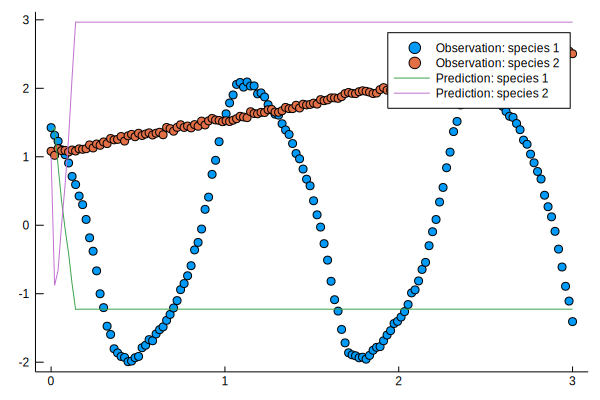

In [6]:
# Call n_ode to get first prediction and to show startpoint for training.
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = "Observation: species 1", grid = "off")
scatter!(t, ode_data[2,:], label = "Observation: species 2")
plot!(t, Flux.data(pred[1,:]), label = "Prediction: species 1")
plot!(t, Flux.data(pred[2,:]), label = "Prediction: species 2")

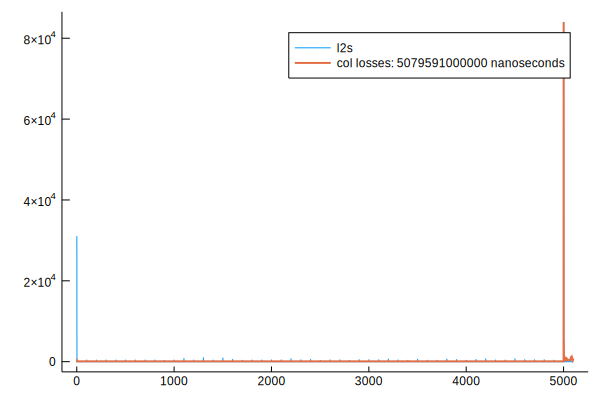

In [7]:
header = string("col losses: ", sa.times[end] - sa.times[1])
plot(range(1,stop=length(sa.l2s)),sa.l2s,label = "l2s", grid = "off")
plot!(range(1,stop=length(sa.losses)),sa.losses,width  =2, label = header)

In [17]:
#l2 vs first coll then l2
140080000000/786320000000

0.17814630176009766